In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.7 MB/s eta 0:00:00


## Modules and Packages

In [7]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from skimage.feature import hog
from skimage import data, exposure
from skimage import img_as_ubyte

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from kerastuner.tuners import RandomSearch
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator


import time
import joblib

# Section A. Data Augmentation

I used this documentation to read about Image Data Generator
1.https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
2.https://www.analyticsvidhya.com/blog/2020/08/image-augmentation-on-the-fly-using-keras-imagedatagenerator/

This video helped understand how to implement data augmentation and i used it as reference to make this code.
https://www.youtube.com/watch?v=sM2C-SsREgM

####Step 1. Extracting the images and labels

In [ ]:
#defining paths to train folder
train_folder = "/content/drive/MyDrive/CW_Folder_PG/CW_Dataset/train/"
images_folder = os.path.join(train_folder, "images")
labels_folder = os.path.join(train_folder, "labels")

#defining arrays to store images and labels for each class
class_0_images = []
class_1_images = []
class_2_images = []

class_0_labels = []
class_1_labels = []
class_2_labels = []

#defining target size for resizing
target_size = (64, 64)

#iterate through the images folder to read images and their corresponding labels
for filename in os.listdir(images_folder):
    if filename.endswith(".jpeg"):
        print("Reading image:", filename)
        #reading image
        img = cv2.imread(os.path.join(images_folder, filename))

        #resizing image to target size
        img = cv2.resize(img, target_size)

        #reading label from corresponding text file
        label_filename = filename[:-5] + ".txt"
        with open(os.path.join(labels_folder, label_filename), 'r') as file:
            label = int(file.readline().strip())
            print("Label:", label)

        #appending image and label to respective class arrays
        if label == 0:
            class_0_images.append(img)
            class_0_labels.append(label)
        elif label == 1:
            class_1_images.append(img)
            class_1_labels.append(label)
        elif label == 2:
            class_2_images.append(img)
            class_2_labels.append(label)

#Converting lists to numpy arrays
class_0_images = np.array(class_0_images)
class_1_images = np.array(class_1_images)
class_2_images = np.array(class_2_images)

class_0_labels = np.array(class_0_labels)
class_1_labels = np.array(class_1_labels)
class_2_labels = np.array(class_2_labels)

#Printing the shape of each array to verify
print("Class 0 images shape:", class_0_images.shape)
print("Class 1 images shape:", class_1_images.shape)
print("Class 2 images shape:", class_2_images.shape)

print("Class 0 labels shape:", class_0_labels.shape)
print("Class 1 labels shape:", class_1_labels.shape)
print("Class 2 labels shape:", class_2_labels.shape)


Reading image: image_1321.jpeg
Label: 1
Reading image: image_1404.jpeg
Label: 1
Reading image: image_1481.jpeg
Label: 1
Reading image: image_1372.jpeg
Label: 1
Reading image: image_1270.jpeg
Label: 1
Reading image: image_1557.jpeg
Label: 1
Reading image: image_1411.jpeg
Label: 1
Reading image: image_1504.jpeg
Label: 1
Reading image: image_1277.jpeg
Label: 1
Reading image: image_1227.jpeg
Label: 1
Reading image: image_1347.jpeg
Label: 1
Reading image: image_1416.jpeg
Label: 1
Reading image: image_1302.jpeg
Label: 1
Reading image: image_1500.jpeg
Label: 1
Reading image: image_1369.jpeg
Label: 1
Reading image: image_1425.jpeg
Label: 1
Reading image: image_1223.jpeg
Label: 0
Reading image: image_1438.jpeg
Label: 0
Reading image: image_1400.jpeg
Label: 2
Reading image: image_1341.jpeg
Label: 1
Reading image: image_1214.jpeg
Label: 1
Reading image: image_1346.jpeg
Label: 1
Reading image: image_1203.jpeg
Label: 1
Reading image: image_1572.jpeg
Label: 1
Reading image: image_1559.jpeg
Label: 1


####Step 2. Data Augmentation for Class 2

In [ ]:
#defining augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

#data augmentation for class 2 images
augmented_class_2_images = []
for img in class_2_images:
    img = np.expand_dims(img, axis=0)
    aug_iter = datagen.flow(img, batch_size=1)
    for _ in range(13):  #this will generate 13 new images for every image
        augmented_image = next(aug_iter)[0].astype(np.uint8)
        augmented_class_2_images.append(augmented_image)

#convert augmented images to numpy array
augmented_class_2_images = np.array(augmented_class_2_images)

#print the shape of augmented class 2 images to verify
print("Augmented class 2 images shape:", augmented_class_2_images.shape)


Augmented class 2 images shape: (1014, 64, 64, 3)


In [ ]:
#Assigning labels to augmented class 2 images
augmented_class_2_labels = np.repeat(class_2_labels, 13)  # Repeat each label 10 times

augmented_class_2_labels

array([2, 2, 2, ..., 2, 2, 2])

In [ ]:
len(augmented_class_2_labels)

1014

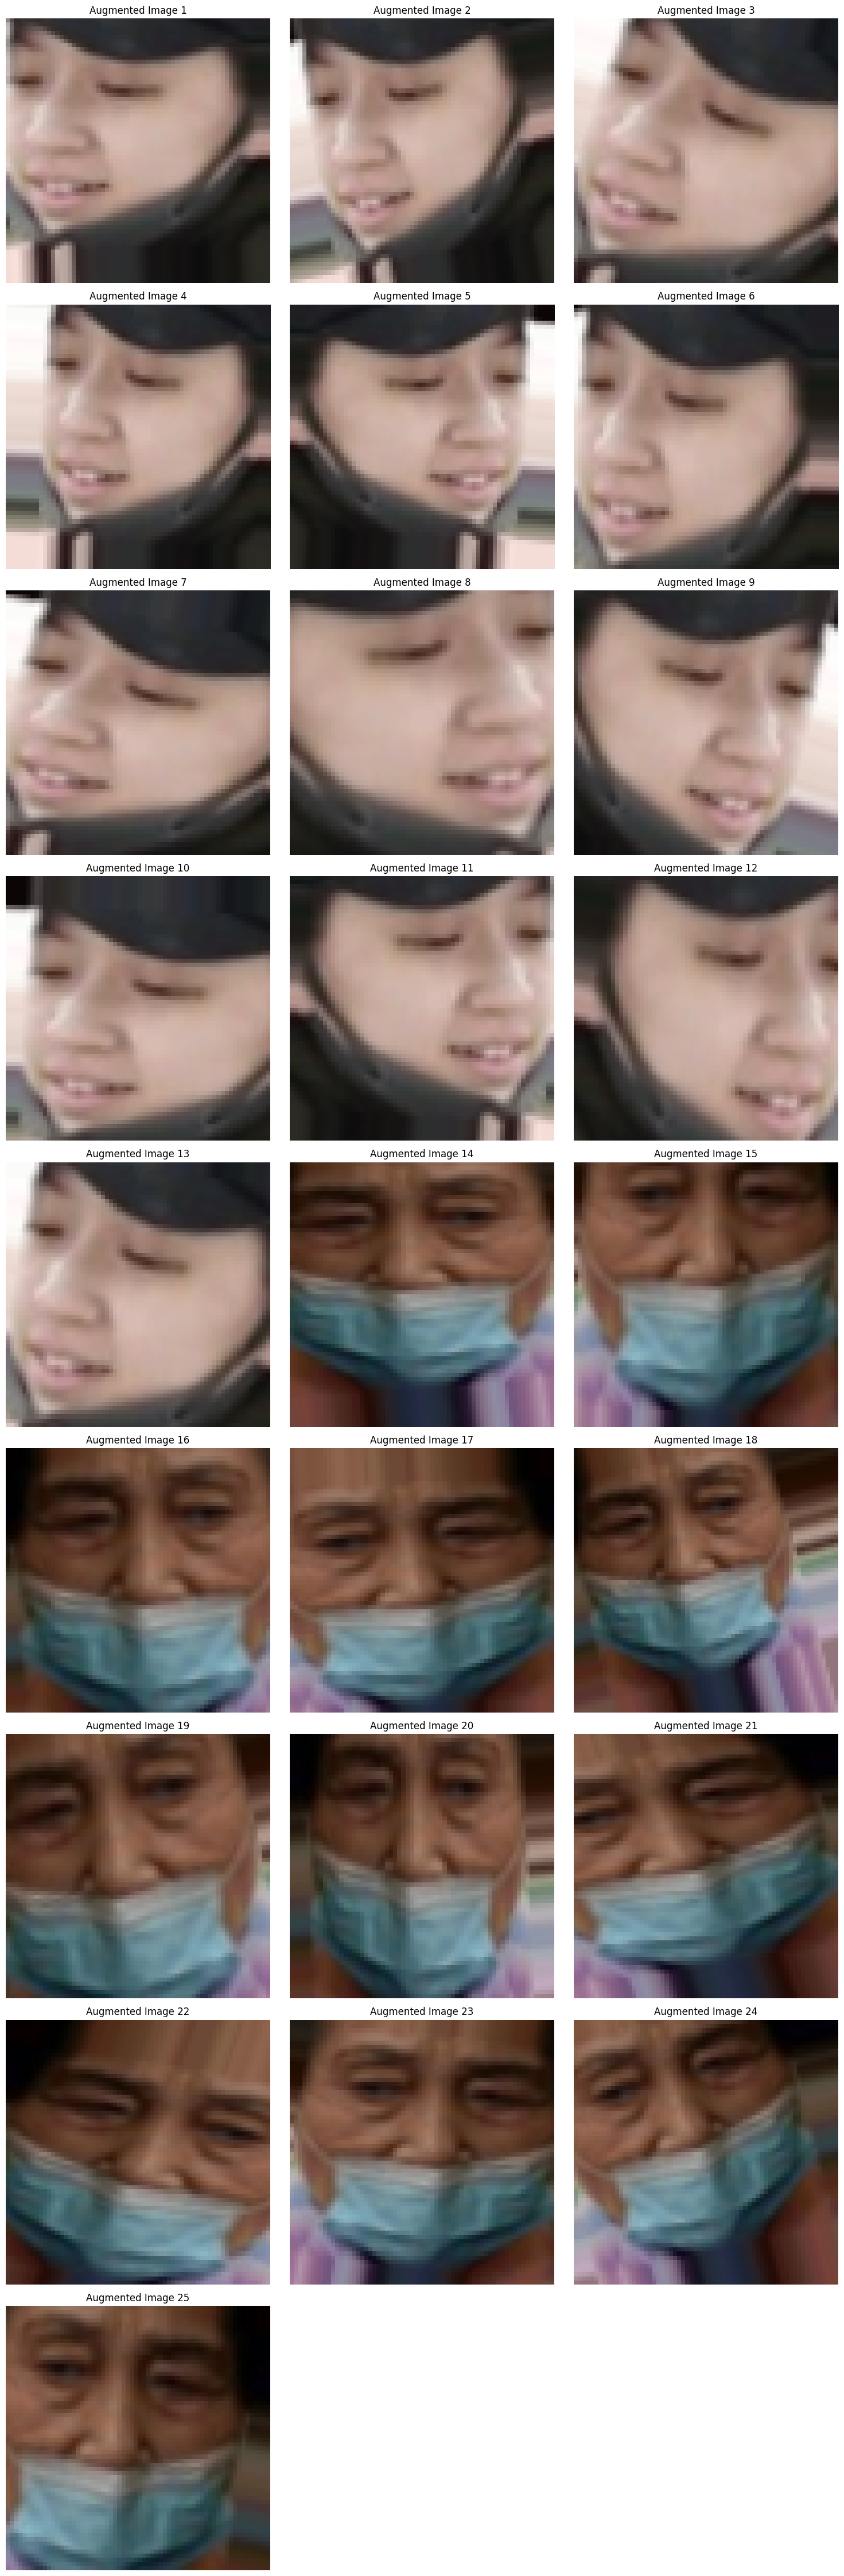

In [ ]:
#defining number of augmented images to display
num_images_to_display = 25
num_images_per_row = 3
num_rows = (num_images_to_display + num_images_per_row - 1) // num_images_per_row

#convert augmented images to RGB format
rgb_augmented_images = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in augmented_class_2_images]

#displaying the augmented images
plt.figure(figsize=(15, 5 * num_rows))
for i in range(num_images_to_display):
    plt.subplot(num_rows, num_images_per_row, i + 1)
    plt.imshow(rgb_augmented_images[i])
    plt.title(f"Augmented Image {i + 1}")
    plt.axis("off")
plt.tight_layout()
plt.show()


####Step 3. Data Augmentation for Class 0

In [ ]:
#defining augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

#data augmentation for class 2 images
augmented_class_0_images = []
for img in class_0_images:
    img = np.expand_dims(img, axis=0)
    aug_iter = datagen.flow(img, batch_size=1)
    for _ in range(3):  # this will generate 3 new images for every image
        augmented_image = next(aug_iter)[0].astype(np.uint8)
        augmented_class_0_images.append(augmented_image)

#converting augmented images to numpy array
augmented_class_0_images = np.array(augmented_class_0_images)

#printing the shape of augmented class 2 images to verify
print("Augmented class 0 images shape:", augmented_class_0_images.shape)

Augmented class 0 images shape: (1128, 64, 64, 3)


In [ ]:
#Assigning labels to augmented class 2 images
augmented_class_0_labels = np.repeat(class_0_labels, 3)  #Repeating each label 10 times

augmented_class_0_labels

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
len(augmented_class_0_labels)

1128

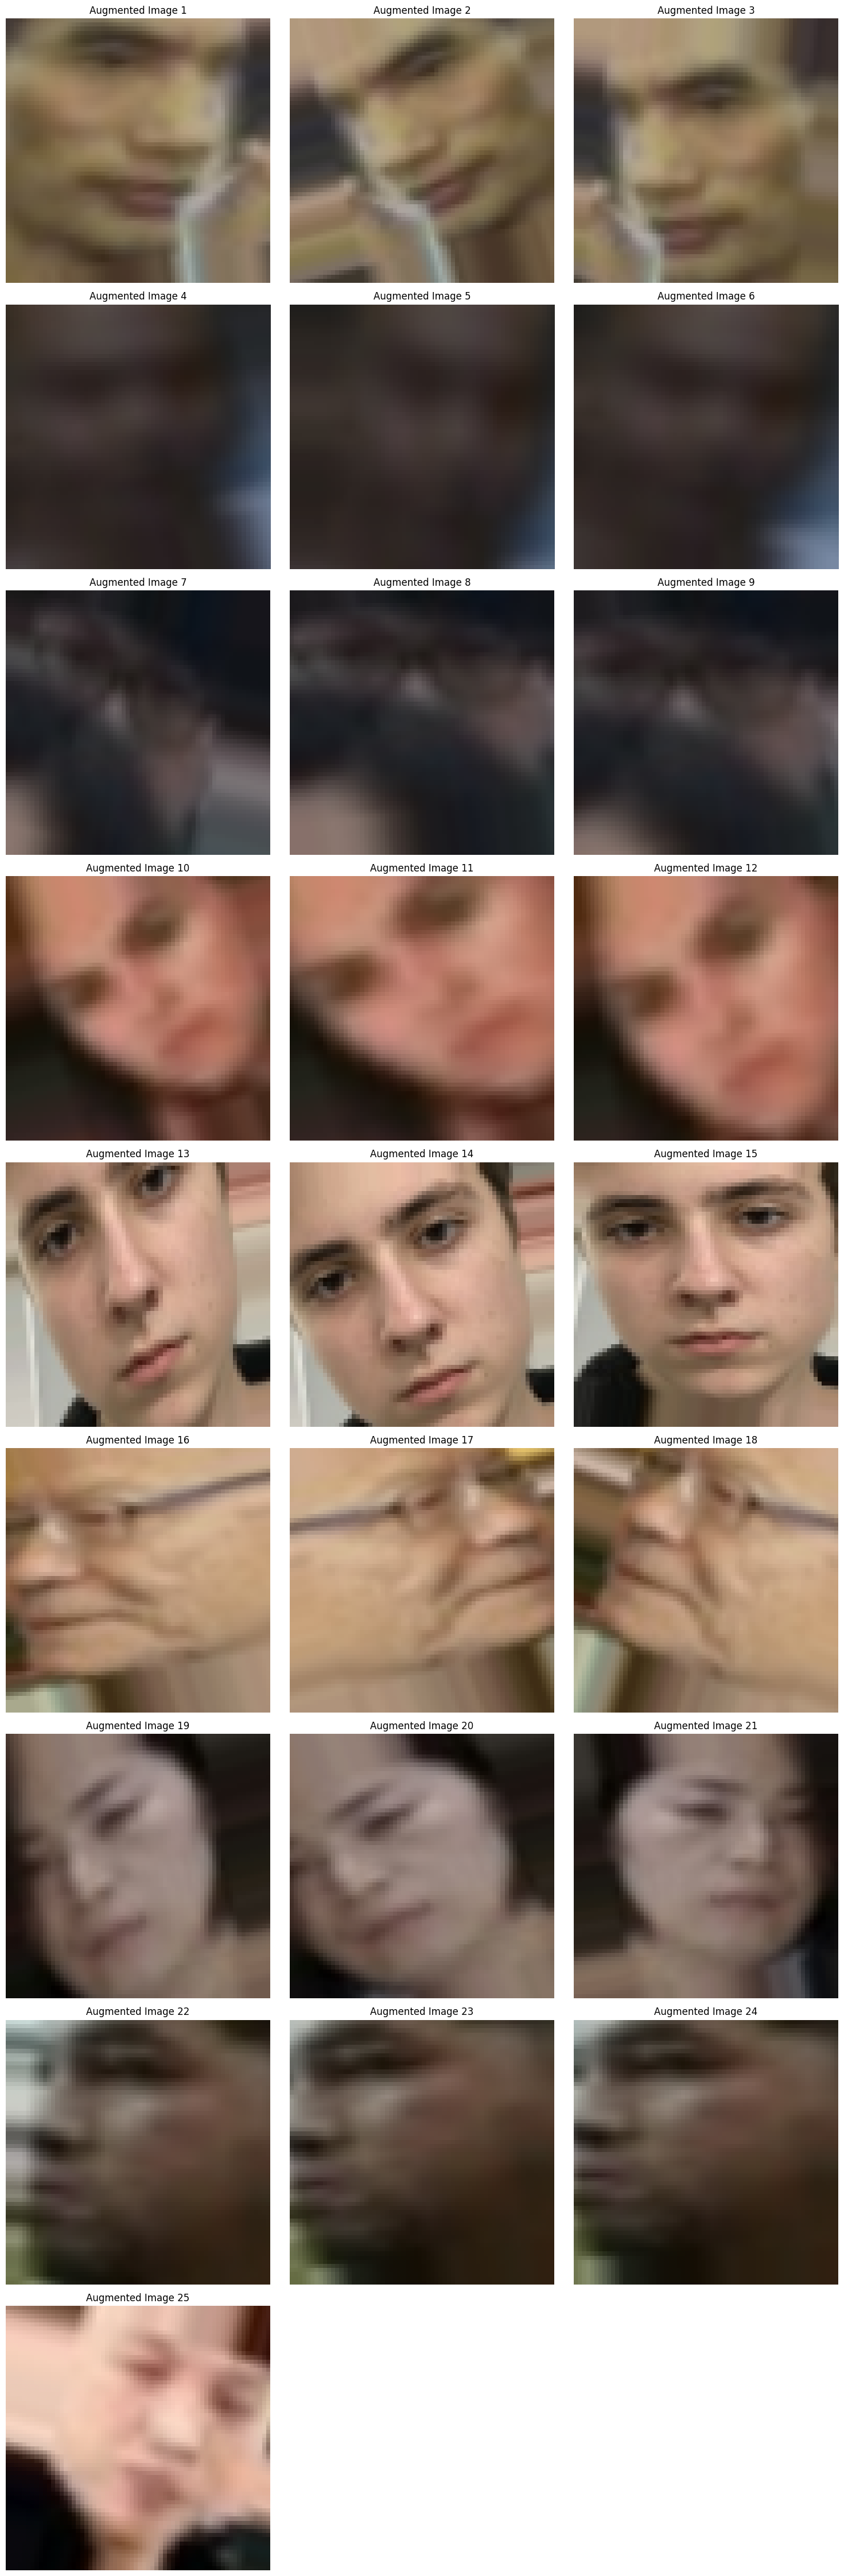

In [ ]:
#defining number of augmented images to display
num_images_to_display = 25
num_images_per_row = 3
num_rows = (num_images_to_display + num_images_per_row - 1) // num_images_per_row

#converting augmented images to RGB format
rgb_augmented_images = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in augmented_class_0_images]

#displaying the augmented images
plt.figure(figsize=(15, 5 * num_rows))
for i in range(num_images_to_display):
    plt.subplot(num_rows, num_images_per_row, i + 1)
    plt.imshow(rgb_augmented_images[i])
    plt.title(f"Augmented Image {i + 1}")
    plt.axis("off")
plt.tight_layout()
plt.show()


####Step 4. Concatenating the Array

In [ ]:
#Concatenating the 3 arrays
augmented_X_train = np.concatenate((augmented_class_0_images, augmented_class_2_images, class_1_images), axis=0)


#printing the shape of the concatenated array to verify
print("Shape of concatenated array:", augmented_X_train.shape)


Shape of concatenated array: (4082, 64, 64, 3)


In [ ]:
augmented_y_train = np.concatenate((augmented_class_0_labels, augmented_class_2_labels, class_1_labels), axis=0)

#Print the shape of the concatenated array to verify
print("Shape of concatenated array:", augmented_y_train.shape)


Shape of concatenated array: (4082,)


In [ ]:
augmented_y_train

array([0, 0, 0, ..., 1, 1, 1])

####Step 5. Shuffling the dataset

In [ ]:
#random permutation of indices
indices = np.random.permutation(len(augmented_y_train))

#using the permutation to shuffle both augmented_X_train and augmented_y_train arrays
augmented_X_train_shuffled = augmented_X_train[indices]
augmented_y_train_shuffled = augmented_y_train[indices]

#verifying the shapes
print("Shape of shuffled x_train:", augmented_X_train_shuffled.shape)
print("Shape of shuffled y_train:", augmented_y_train_shuffled.shape)


Shape of shuffled x_train: (4082, 64, 64, 3)
Shape of shuffled y_train: (4082,)


In [ ]:
augmented_y_train_shuffled

array([2, 0, 0, ..., 0, 2, 1])

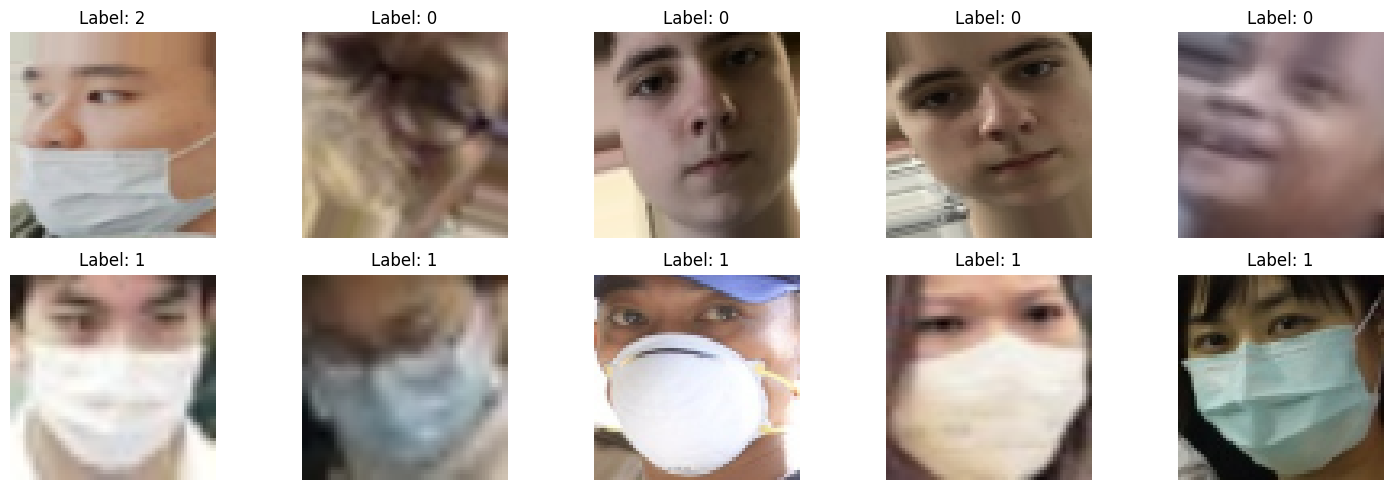

In [ ]:
#defining number of images to display
num_images_to_display = 10  # Adjust this as needed

#Converting images from BGR to RGB format
rgb_images = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in augmented_X_train_shuffled]

#displaying shuffled images along with their labels
plt.figure(figsize=(15, 5))
for i in range(num_images_to_display):
    plt.subplot(2, num_images_to_display // 2, i + 1)
    plt.imshow(rgb_images[i])
    plt.title(f"Label: {augmented_y_train_shuffled[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()


# Section B. Preprocessing for Test Images

In [ ]:
def load_images_and_labels(image_folder, label_folder, target_size=(64, 64)):
    image_paths = sorted([os.path.join(image_folder, img) for img in os.listdir(image_folder)])
    label_paths = sorted([os.path.join(label_folder, label) for label in os.listdir(label_folder)])

    images = []
    labels = []

    for img_path, label_path in zip(image_paths, label_paths):

        #load image
        image = cv2.imread(img_path)

        #resizing image
        image = cv2.resize(image, target_size)

        images.append(image)

        #load labels
        with open(label_path, 'r') as file:
            label = file.read().strip()
        labels.append(label)

    #performing label encoding
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)

    return np.array(images), labels_encoded


image_folder_test = "/content/drive/MyDrive/CW_Folder_PG/CW_Dataset/test/images"
label_folder_test = "/content/drive/MyDrive/CW_Folder_PG/CW_Dataset/test/labels"

images_test, labels_test = load_images_and_labels(image_folder_test, label_folder_test)


X_test = images_test
y_test = labels_test


In [ ]:
#y_test count
test_counts = np.bincount(y_test)

print("Test label counts:", test_counts)

Test label counts: [ 51 388  19]


In [ ]:
save_dir = "/content/drive/MyDrive/CW_Folder_PG/Formatted_Datasets/Augmented_arrays_(resized)/"

#saving X_train_whole and y_train_whole
np.save(os.path.join(save_dir, 'X_train_whole.npy'), augmented_X_train_shuffled) #augmented_X_train_shuffled
np.save(os.path.join(save_dir, 'y_train_whole.npy'), augmented_y_train_shuffled) #augmented_y_train_shuffled

#saving X_test and y_test
np.save(os.path.join(save_dir, 'X_test.npy'), X_test)
np.save(os.path.join(save_dir, 'y_test.npy'), y_test)


In [ ]:
load_dir = "/content/drive/MyDrive/CW_Folder_PG/Formatted_Datasets/Augmented_arrays_(resized)/"

# Load the saved arrays
X_train_whole = np.load(os.path.join(load_dir, 'X_train_whole.npy'))
y_train_whole = np.load(os.path.join(load_dir, 'y_train_whole.npy'))
X_test = np.load(os.path.join(load_dir, 'X_test.npy'))
y_test = np.load(os.path.join(load_dir, 'y_test.npy'))



#Section C. Preprocessing for HOG and SIFT

In [ ]:
#Defining a function to preprocess images
def preprocess_images(images):
    preprocessed_images = []
    for img in images:
        #Converting to grayscale
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        #Normalize
        normalized_img = gray_img / 255.0
        preprocessed_images.append(normalized_img)
    return np.array(preprocessed_images)

#Preprocessing X_train_whole
X_train_whole_preprocessed = preprocess_images(X_train_whole)

#Preprocessing X_test
X_test_preprocessed = preprocess_images(X_test)


In [ ]:
#Splitting the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_whole_preprocessed, y_train_whole, test_size=0.2, random_state=42)


In [ ]:
#X_train, X_val, y_train, y_val, X_test_preprocessed, y_test

#Section D. HOG

The codes in this section for HOG features extraction were adapted from lab 5.

####Step 1. Display the first 5 images

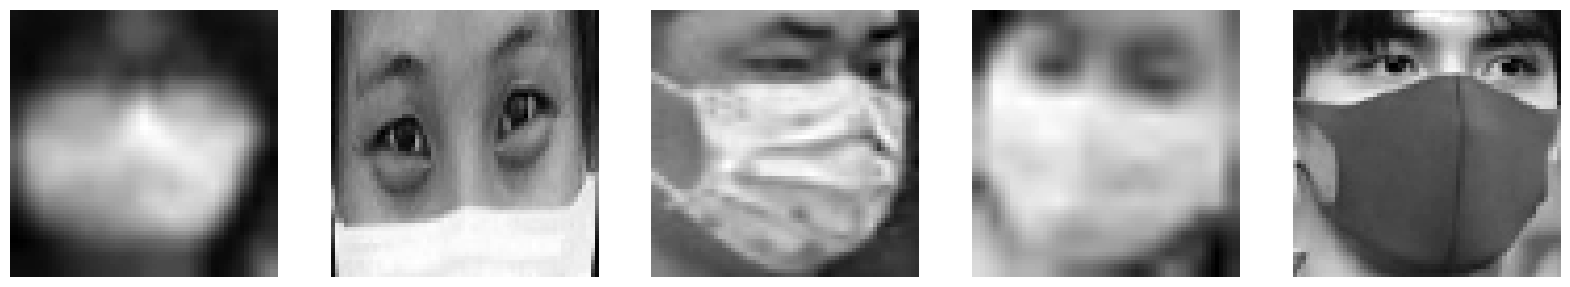

In [ ]:
#Displaying the first 5 images

import matplotlib.pyplot as plt
fig, axes = plt.subplots(1,5, figsize=(20,4))
for i, ax in enumerate (axes):
    if i < len(X_train):

        ax.imshow(X_train[i], cmap='gray')
        ax.axis('off')
plt.show()

####Step 2. Initialize list to store HOG features and images for training images

In [ ]:
hog_features = []
hog_images = []

#extracting HOG Features from train image
for image in X_train:
    #ensure the image is 2D
    if image.ndim == 2:
        HOG_des, HOG_image = hog(image, orientations=8, pixels_per_cell=(16,16), cells_per_block=(1,1), visualize=True)
        hog_features.append(HOG_des)
        hog_images.append(HOG_image)

    else:
        print ("Image is not 2D")


####Step 3. Comparing Original Image with HOG Image

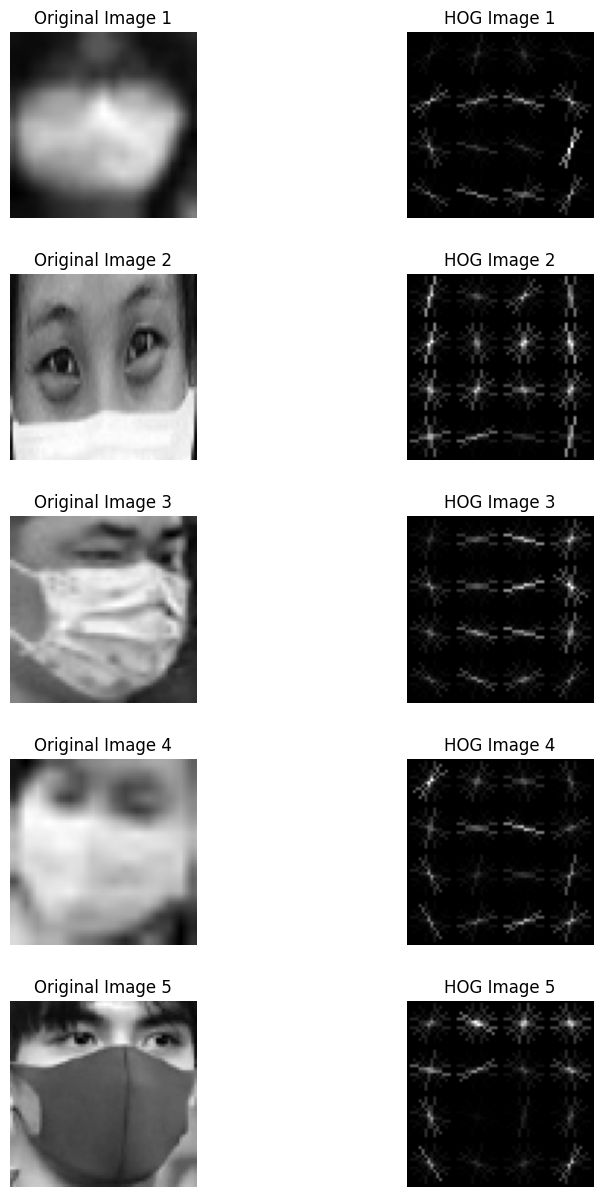

In [ ]:
fig, axes = plt.subplots(5, 2, figsize=(10, 15))

plt.subplots_adjust(hspace=0.3, wspace=0.05)

num_images = min(len(X_train), len(hog_images), 5)
for i in range(num_images):
    # Original image
    axes[i, 0].axis('off')
    axes[i, 0].imshow(X_train[i], cmap='gray')
    axes[i, 0].set_title(f'Original Image {i + 1}')

    # HOG image
    HOG_image_rescaled = exposure.rescale_intensity(hog_images[i], in_range=(0, 10))
    axes[i, 1].axis('off')
    axes[i, 1].imshow(HOG_image_rescaled, cmap='gray')
    axes[i, 1].set_title(f'HOG Image {i + 1}')

plt.show()

####Step 4. Printing HOG Features

In [ ]:
#the number of HOG features to print
num_features_to_print = min(5, len(hog_features))

#HOG features for the determined number of images
for i in range(num_features_to_print):
    print(f"HOG features for image {i+1}:")
    print(hog_features[i])
    print("\n")

HOG features for image 1:
[0.48751994 0.48751994 0.48751994 0.38459027 0.35184435 0.02661389
 0.11919045 0.01881886 0.38912897 0.38912897 0.38912897 0.38912897
 0.38912897 0.22242543 0.20493604 0.38912897 0.38592995 0.38592995
 0.38592995 0.17540026 0.38592995 0.27492399 0.38592995 0.38592995
 0.37395788 0.09145885 0.26394916 0.07952412 0.47695075 0.47695075
 0.47695075 0.30553475 0.31748476 0.52830068 0.52830068 0.52830068
 0.24879427 0.         0.         0.         0.20333714 0.4587354
 0.4587354  0.4587354  0.4587354  0.33751922 0.03892331 0.03830274
 0.00335566 0.         0.2349123  0.51194651 0.51194651 0.51194651
 0.39816736 0.         0.44715176 0.         0.01427842 0.00852395
 0.44715176 0.44715176 0.44715176 0.44715176 0.42506778 0.03766565
 0.06800005 0.30090565 0.42506778 0.42506778 0.42506778 0.42506778
 0.27029364 0.08512245 0.32368558 0.48605295 0.48605295 0.35728612
 0.36594918 0.28435199 0.21781875 0.24624515 0.446878   0.24166718
 0.446878   0.446878   0.446878   0.1

#### Step 5. Initialize list to store HOG features and images for validation images

In [ ]:
hog_features_val = []
hog_images_val = []

#extracting HOG features from val image
for image in X_val:
    #Ensure the image is 2D
    if image.ndim == 2:
        HOG_des_val, HOG_image_val = hog(image, orientations=8, pixels_per_cell=(16,16), cells_per_block=(1,1), visualize=True)
        hog_features_val.append(HOG_des_val)
        hog_images_val.append(HOG_image_val)

    else:
        print ("Image is not 2D.")




####Step 6. Initialize list to store HOG features and images for test images

In [ ]:
hog_features_test = []
hog_images_test = []

#extract HOG Features from test image
for image in X_test_preprocessed:
    #Ensure the image is 2D
    if image.ndim == 2:
        HOG_des_test, HOG_image_test = hog(image, orientations=8, pixels_per_cell=(16,16), cells_per_block=(1,1), visualize=True)
        hog_features_test.append(HOG_des_test)
        hog_images_test.append(HOG_image_test)

    else:
        print ("Image is not 2D")

#### Step 7. Converting to Numpy Array

In [ ]:
# Convert list to NumPy array
hog_features_train_array = np.array(hog_features)

hog_features_val_array = np.array(hog_features_val)

hog_features_test_array = np.array(hog_features_test)

In [ ]:
#saving the hog arrays



# defining file paths to save the arrays
train_array_file = '/content/drive/MyDrive/CW_Folder_PG/Formatted_Datasets/HOG Arrays/train_array.npy'
val_array_file = '/content/drive/MyDrive/CW_Folder_PG/Formatted_Datasets/HOG Arrays/validation_array.npy'
test_array_file = '/content/drive/MyDrive/CW_Folder_PG/Formatted_Datasets/HOG Arrays/test_array.npy'

y_train_file = '/content/drive/MyDrive/CW_Folder_PG/Formatted_Datasets/HOG Arrays/y_train.npy'
y_val_file = '/content/drive/MyDrive/CW_Folder_PG/Formatted_Datasets/HOG Arrays/y_val.npy'
y_test_file = '/content/drive/MyDrive/CW_Folder_PG/Formatted_Datasets/HOG Arrays/y_test.npy'

# Save numpy arrays
np.save(train_array_file, hog_features_train_array)
np.save(val_array_file, hog_features_val_array)
np.save(test_array_file, hog_features_test_array)

np.save(y_train_file, y_train)
np.save(y_val_file , y_val)
np.save(y_test_file, y_test)


#### Step 8. Converting Numpy arrays to tensors

In [10]:
#Converting to tensors

X_train_tensor = tf.convert_to_tensor(hog_features_train_array)
y_train_tensor = tf.convert_to_tensor(y_train)

X_val_tensor = tf.convert_to_tensor(hog_features_val_array)
y_val_tensor = tf.convert_to_tensor(y_val)

X_test_tensor = tf.convert_to_tensor(hog_features_test_array)
y_test_tensor = tf.convert_to_tensor(y_test)

In [ ]:
len(X_val_tensor)

817

# Section E. HOG + MLP (Model 1)

I used this link to understand how to implement a MLP model.
https://www.kaggle.com/code/sathianpong/3-ways-to-implement-mlp-with-keras

####Step 1. Loading the data

In [ ]:
#defining file paths to load the arrays
train_array_file = '/content/drive/MyDrive/CW_Folder_PG/Formatted_Datasets/HOG Arrays/train_array.npy'
val_array_file = '/content/drive/MyDrive/CW_Folder_PG/Formatted_Datasets/HOG Arrays/validation_array.npy'
test_array_file = '/content/drive/MyDrive/CW_Folder_PG/Formatted_Datasets/HOG Arrays/test_array.npy'

#defining file paths to load the arrays
y_train_file = '/content/drive/MyDrive/CW_Folder_PG/Formatted_Datasets/HOG Arrays/y_train.npy'
y_val_file = '/content/drive/MyDrive/CW_Folder_PG/Formatted_Datasets/HOG Arrays/y_val.npy'
y_test_file = '/content/drive/MyDrive/CW_Folder_PG/Formatted_Datasets/HOG Arrays/y_test.npy'

#Load numpy arrays
hog_features_train_array = np.load(train_array_file)
hog_features_val_array = np.load(val_array_file)
hog_features_test_array = np.load(test_array_file)

#Load numpy arrays
y_train = np.load(y_train_file)
y_val = np.load(y_val_file)
y_test = np.load(y_test_file)

In [ ]:
#Converting to tensors

X_train_tensor = tf.convert_to_tensor(hog_features_train_array)
y_train_tensor = tf.convert_to_tensor(y_train)

X_val_tensor = tf.convert_to_tensor(hog_features_val_array)
y_val_tensor = tf.convert_to_tensor(y_val)

X_test_tensor = tf.convert_to_tensor(hog_features_test_array)
y_test_tensor = tf.convert_to_tensor(y_test)

####Step 2. Base Model

In [ ]:
#random seed for tensorflow
tf.random.set_seed(42)

#random seed for numpy
np.random.seed(42)

#defining the model architecture
model_mlp_hog_1 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=X_train_tensor.shape[1:]),  #flattening the input images
    tf.keras.layers.Dense(128, activation='relu'),                  #First hidden layer with 128 neurons and ReLU activation
    tf.keras.layers.Dense(64, activation='relu'),                   #Second hidden layer with 64 neurons and ReLU activation
    tf.keras.layers.Dense(3, activation='softmax')                  #Output layer for 3 classes
])

# Compile the model
model_mlp_hog_1.compile(optimizer='adam',  #adam optimizer
              loss='sparse_categorical_crossentropy',  # Sparse categorical crossentropy loss
              metrics=['accuracy'])

#early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

#training the model with early stopping and validation data
history = model_mlp_hog_1.fit(X_train_tensor, y_train_tensor, epochs=50, batch_size=32,
                    validation_data=(X_val_tensor, y_val_tensor), callbacks=[early_stopping])

#access loss and accuracy from the history object
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

#the final loss and accuracy
final_loss = train_loss[-1]
final_accuracy = train_accuracy[-1]
print("Final training loss:", final_loss)
print("Final training accuracy:", final_accuracy)

#final validation loss and accuracy
final_val_loss = val_loss[-1]
final_val_accuracy = val_accuracy[-1]
print("Final validation loss:", final_val_loss)
print("Final validation accuracy:", final_val_accuracy)


Epoch 1/50
103/103 [==============================] - 1s 5ms/step - loss: 0.8906 - accuracy: 0.5786 - val_loss: 0.8107 - val_accuracy: 0.6047
Epoch 2/50
103/103 [==============================] - 0s 2ms/step - loss: 0.7141 - accuracy: 0.6827 - val_loss: 0.6576 - val_accuracy: 0.7148
Epoch 3/50
103/103 [==============================] - 0s 3ms/step - loss: 0.6524 - accuracy: 0.7216 - val_loss: 0.6193 - val_accuracy: 0.7417
Epoch 4/50
103/103 [==============================] - 0s 2ms/step - loss: 0.6084 - accuracy: 0.7332 - val_loss: 0.5973 - val_accuracy: 0.7405
Epoch 5/50
103/103 [==============================] - 0s 3ms/step - loss: 0.5977 - accuracy: 0.7381 - val_loss: 0.6579 - val_accuracy: 0.7430
Epoch 6/50
103/103 [==============================] - 0s 2ms/step - loss: 0.6000 - accuracy: 0.7317 - val_loss: 0.5973 - val_accuracy: 0.7160
Epoch 7/50
103/103 [==============================] - 0s 2ms/step - loss: 0.5712 - accuracy: 0.7507 - val_loss: 0.5473 - val_accuracy: 0.7650
Epoch 

In [ ]:
#On test set

#the model on the test set
test_loss, test_accuracy = model_mlp_hog_1.evaluate(X_test_tensor, y_test_tensor)

#printing the test loss and accuracy
print("Test loss:", test_loss)
print("Test accuracy:", test_accuracy)

15/15 [==============================] - 0s 2ms/step - loss: 0.5807 - accuracy: 0.7795
Test loss: 0.5807031989097595
Test accuracy: 0.77947598695755


15/15 [==============================] - 0s 1ms/step


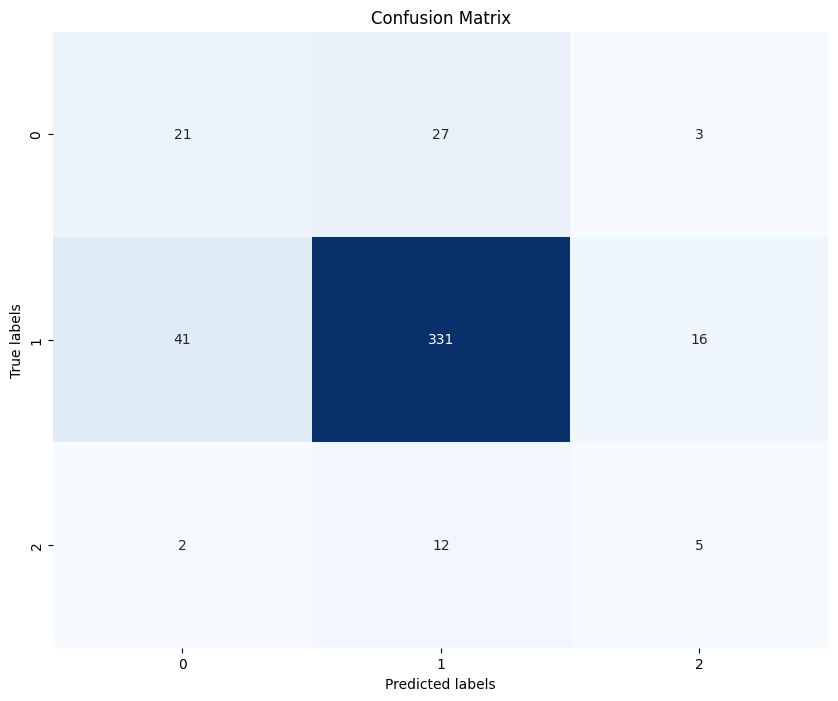

In [ ]:
#Confusion Matrix

#predicted probabilities
y_pred_probs = model_mlp_hog_1.predict(X_test_tensor)

#finding the predicted classes by finding the index of the maximum probability
y_pred = np.argmax(y_pred_probs, axis=1)

#calculating confusion matrix
conf_matrix = confusion_matrix(y_test_tensor, y_pred)

#confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

#### Step 3. Tuning the Multi Layer Perceptron

In [ ]:
#random seed for tensorflow
tf.random.set_seed(42)

#random seed for numpy
np.random.seed(42)

#the hyperparameters to tune
neurons_hidden1_options = [64, 128, 256]
neurons_hidden2_options = [64, 128, 256]
dropout_rate_options = [0.0, 0.1, 0.2]
learning_rates = [0.001, 0.01, 0.1]
optimizers = ['adam', 'rmsprop', 'sgd']

best_accuracy = 0
best_hyperparameters = {}

#Iterating over each combination of hyperparameters
for neurons_hidden1 in neurons_hidden1_options:
    for neurons_hidden2 in neurons_hidden2_options:
        for dropout_rate in dropout_rate_options:
            for learning_rate in learning_rates:
                for optimizer in optimizers:
                    print("Training model with neurons_hidden1={}, neurons_hidden2={}, dropout_rate={}, learning_rate={}, optimizer={}".format(neurons_hidden1, neurons_hidden2, dropout_rate, learning_rate, optimizer))

                    #defining the model architecture
                    model_mlp_hog_tuning = tf.keras.Sequential([
                        tf.keras.layers.Flatten(input_shape=X_train_tensor.shape[1:]),
                        tf.keras.layers.Dense(neurons_hidden1, activation='relu'),
                        tf.keras.layers.Dropout(dropout_rate),
                        tf.keras.layers.Dense(neurons_hidden2, activation='relu'),
                        tf.keras.layers.Dropout(dropout_rate),
                        tf.keras.layers.Dense(3, activation='softmax')
                    ])

                    #Compiling the model
                    model_mlp_hog_tuning.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

                    #early stopping
                    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

                    #train the model
                    history = model_mlp_hog_tuning.fit(X_train_tensor, y_train_tensor, epochs=50, batch_size=32,
                                        validation_data=(X_val_tensor, y_val_tensor), verbose=0,
                                        callbacks=[early_stopping])

                    #evaluate the model on validation data
                    _, accuracy = model_mlp_hog_tuning.evaluate(X_val_tensor, y_val_tensor, verbose=0)
                    print("Validation accuracy:", accuracy)

                    #Checking if this model has better accuracy than the previous best
                    if accuracy > best_accuracy:
                        best_accuracy = accuracy
                        best_hyperparameters = {'neurons_hidden1': neurons_hidden1, 'neurons_hidden2': neurons_hidden2,
                                                'dropout_rate': dropout_rate, 'learning_rate': learning_rate,
                                                'optimizer': optimizer}

                    #print accuracy for each combination
                    print("Accuracy for neurons_hidden1={}, neurons_hidden2={}, dropout_rate={}, learning_rate={}, optimizer={}: {:.4f}".format(
                        neurons_hidden1, neurons_hidden2, dropout_rate, learning_rate, optimizer, accuracy))

print("Best hyperparameters:", best_hyperparameters)
print("Best validation accuracy:", best_accuracy)


Training model with neurons_hidden1=64, neurons_hidden2=64, dropout_rate=0.0, learning_rate=0.001, optimizer=adam
Restoring model weights from the end of the best epoch: 28.
Epoch 33: early stopping
Validation accuracy: 0.8017135858535767
Accuracy for neurons_hidden1=64, neurons_hidden2=64, dropout_rate=0.0, learning_rate=0.001, optimizer=adam: 0.8017
Training model with neurons_hidden1=64, neurons_hidden2=64, dropout_rate=0.0, learning_rate=0.001, optimizer=rmsprop
Restoring model weights from the end of the best epoch: 7.
Epoch 12: early stopping
Validation accuracy: 0.7429620623588562
Accuracy for neurons_hidden1=64, neurons_hidden2=64, dropout_rate=0.0, learning_rate=0.001, optimizer=rmsprop: 0.7430
Training model with neurons_hidden1=64, neurons_hidden2=64, dropout_rate=0.0, learning_rate=0.001, optimizer=sgd
Restoring model weights from the end of the best epoch: 35.
Epoch 40: early stopping
Validation accuracy: 0.7307221293449402
Accuracy for neurons_hidden1=64, neurons_hidden2=

#### Step 4. Making the new Model with the best Hyperparameters

In [ ]:
#random seed for tensorflow
tf.random.set_seed(42)

#random seed for numpy
np.random.seed(42)

#defining the model architecture
model_mlp_hog_2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=X_train_tensor.shape[1:]),  #flattening the input images
    tf.keras.layers.Dense(256, activation='relu'),                  #first hidden layer with 256 neurons and ReLU activation
    tf.keras.layers.Dropout(0.0),                                   #dropout layer with rate of 0.0
    tf.keras.layers.Dense(64, activation='relu'),                   #second hidden layer with 64 neurons and ReLU activation
    tf.keras.layers.Dropout(0.0),                                   #dropout layer with rate of 0.0
    tf.keras.layers.Dense(3, activation='softmax')                  #Output layer for 3 classes
])

#learning rate
learning_rate = 0.001

#compile the model with the adam optimizer and the learning rate
model_mlp_hog_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                        loss='sparse_categorical_crossentropy',  # Sparse categorical crossentropy loss
                        metrics=['accuracy'])

#early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

#train the model with early stopping and validation data
history = model_mlp_hog_2.fit(X_train_tensor, y_train_tensor, epochs=50, batch_size=32,
                    validation_data=(X_val_tensor, y_val_tensor), callbacks=[early_stopping])

#accessing loss and accuracy
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

#Printing the final loss and accuracy
final_loss = train_loss[-1]
final_accuracy = train_accuracy[-1]
print("Final training loss:", final_loss)
print("Final training accuracy:", final_accuracy)

final_val_loss = val_loss[-1]
final_val_accuracy = val_accuracy[-1]
print("Final validation loss:", final_val_loss)
print("Final validation accuracy:", final_val_accuracy)


Epoch 1/50
103/103 [==============================] - 1s 6ms/step - loss: 0.8493 - accuracy: 0.5920 - val_loss: 0.8011 - val_accuracy: 0.5961
Epoch 2/50
103/103 [==============================] - 0s 3ms/step - loss: 0.6927 - accuracy: 0.6904 - val_loss: 0.6358 - val_accuracy: 0.7148
Epoch 3/50
103/103 [==============================] - 0s 3ms/step - loss: 0.6515 - accuracy: 0.7130 - val_loss: 0.6258 - val_accuracy: 0.7417
Epoch 4/50
103/103 [==============================] - 0s 3ms/step - loss: 0.6119 - accuracy: 0.7338 - val_loss: 0.5879 - val_accuracy: 0.7479
Epoch 5/50
103/103 [==============================] - 0s 3ms/step - loss: 0.5921 - accuracy: 0.7381 - val_loss: 0.6500 - val_accuracy: 0.7295
Epoch 6/50
103/103 [==============================] - 0s 3ms/step - loss: 0.5921 - accuracy: 0.7412 - val_loss: 0.6184 - val_accuracy: 0.7099
Epoch 7/50
103/103 [==============================] - 0s 3ms/step - loss: 0.5784 - accuracy: 0.7443 - val_loss: 0.5513 - val_accuracy: 0.7601
Epoch 

#### Step 5. Saving the best model

In [ ]:
#Saving the Model

#the directory and file path
file_path = "/content/drive/MyDrive/CW_Folder_PG/Models/model_mlp_hog_2.h5"

#Save the model
model_mlp_hog_2.save(file_path)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### Step 6. Loading the best model

In [11]:
#path to the saved model
model_path = "/content/drive/MyDrive/CW_Folder_PG/Models/model_mlp_hog_2.h5"

# Load the model
model_mlp_hog_2 = load_model(model_path)


####Step 7. The best model on the unseen test data

In [27]:
#On the unseen test data

#the model on the test data
test_loss, test_accuracy = model_mlp_hog_2.evaluate(X_test_tensor, y_test_tensor)

#Printing the test loss and accuracy
print("Test loss:", test_loss)
print("Test accuracy:", test_accuracy)


15/15 [==============================] - 0s 2ms/step - loss: 0.5896 - accuracy: 0.7598
Test loss: 0.5895785689353943
Test accuracy: 0.7598253488540649


In [28]:
# Calculate precision, recall, and F1-score
precision = precision_score(y_test_tensor, y_pred, average='weighted')
recall = recall_score(y_test_tensor, y_pred, average='weighted')
f1 = f1_score(y_test_tensor, y_pred, average='weighted')

# Print precision, recall, and F1-score
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Precision: 0.8163879234567514
Recall: 0.759825327510917
F1-score: 0.7828527635874748


####Step 8. Confusion Matrix of best model

15/15 [==============================] - 0s 2ms/step


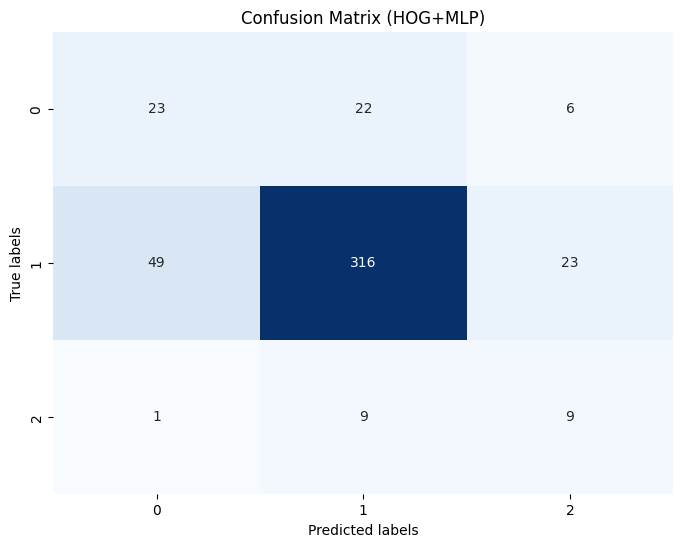

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [21]:
#model's predictions on the test data
y_pred = np.argmax(model_mlp_hog_2.predict(X_test_tensor), axis=-1)

#confusion matrix
conf_matrix = confusion_matrix(y_test_tensor, y_pred)

#plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix (HOG+MLP)')
plt.savefig('confusion_matrix(HOG+MLP).png')
plt.show()

# Download the image
#from google.colab import files
#files.download('confusion_matrix(HOG+MLP).png')


In [29]:
# Generate classification report
report = classification_report(y_test_tensor, y_pred)

# Print classification report
print(report)

              precision    recall  f1-score   support

           0       0.32      0.45      0.37        51
           1       0.91      0.81      0.86       388
           2       0.24      0.47      0.32        19

    accuracy                           0.76       458
   macro avg       0.49      0.58      0.52       458
weighted avg       0.82      0.76      0.78       458



#Section F. HOG + SVM (Model 2)

####Step 1. Loading the data

In [9]:
#defining file paths to load the arrays
train_array_file = '/content/drive/MyDrive/CW_Folder_PG/Formatted_Datasets/HOG Arrays/train_array.npy'
val_array_file = '/content/drive/MyDrive/CW_Folder_PG/Formatted_Datasets/HOG Arrays/validation_array.npy'
test_array_file = '/content/drive/MyDrive/CW_Folder_PG/Formatted_Datasets/HOG Arrays/test_array.npy'

#defining file paths to load the arrays
y_train_file = '/content/drive/MyDrive/CW_Folder_PG/Formatted_Datasets/HOG Arrays/y_train.npy'
y_val_file = '/content/drive/MyDrive/CW_Folder_PG/Formatted_Datasets/HOG Arrays/y_val.npy'
y_test_file = '/content/drive/MyDrive/CW_Folder_PG/Formatted_Datasets/HOG Arrays/y_test.npy'

#Load numpy arrays
hog_features_train_array = np.load(train_array_file)
hog_features_val_array = np.load(val_array_file)
hog_features_test_array = np.load(test_array_file)

#Load numpy arrays
y_train = np.load(y_train_file)
y_val = np.load(y_val_file)
y_test = np.load(y_test_file)


#### Step 2. Base Model

In [ ]:
#Concatenate the training and validation set for svm

#Concatenate X_train and X_val
hog_features_X_train_svm = np.concatenate((hog_features_train_array, hog_features_val_array), axis=0)

#Concatenate y_train and y_val
hog_features_y_train_svm = np.concatenate((y_train, y_val), axis=0)


In [ ]:
#Initializing the SVM classifier
svm_classifier_base_hog = SVC(kernel='linear')

#train the SVM classifier
svm_classifier_base_hog.fit(hog_features_X_train_svm, hog_features_y_train_svm)

#predictions on the train set
y_pred_train = svm_classifier_base_hog.predict(hog_features_X_train_svm)

#accuracy
accuracy = accuracy_score(hog_features_y_train_svm, y_pred_train)
print("Accuracy:", accuracy )

Accuracy: 0.7959333659970602


In [ ]:
#predictions on the testing set
y_pred_test = svm_classifier_base_hog.predict(hog_features_test_array)

#accuracy
test_accuracy = accuracy_score(y_test, y_pred_test)
print("Test Set Accuracy:", test_accuracy)


Test Set Accuracy: 0.7641921397379913


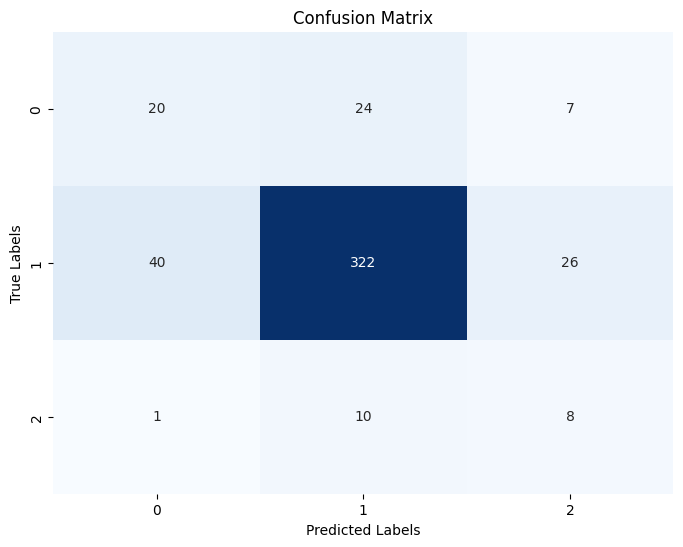

In [ ]:
#confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)

#Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


####Step 3. Random Search

In [ ]:
# defining the parameter grid

parameters = {
    'C': [1, 5, 7, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],                                               #kernel type
    'gamma': ['scale', 'auto']                                                                    #gamma
}

In [ ]:
SvmClassifier_RS_hog1 = SVC()

#recording the start time
start_time = time.time()

random_search = RandomizedSearchCV(SvmClassifier_RS_hog1, param_distributions=parameters, n_iter=100, cv=10, random_state=42)
random_search.fit(hog_features_X_train_svm, hog_features_y_train_svm)

#recording the end time
end_time = time.time()

#Calculating the time taken
time_taken = end_time - start_time
print("Time taken for RandomizedSearchCV:", time_taken, "seconds")

Time taken for RandomizedSearchCV: 2383.5153517723083 seconds


In [ ]:
#best parameters

best_parameters = random_search.best_params_
print(best_parameters)

{'kernel': 'rbf', 'gamma': 'scale', 'C': 7}


In [ ]:
#highest accuracy

highest_accuracy = random_search.best_score_
print(highest_accuracy)

0.8385660865813318


In [ ]:
results = pd.DataFrame(random_search.cv_results_)

In [ ]:
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kernel,param_gamma,param_C,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,2.147931,0.016925,0.135315,0.003731,sigmoid,scale,7,"{'kernel': 'sigmoid', 'gamma': 'scale', 'C': 7}",0.474328,0.474328,...,0.475490,0.475490,0.475490,0.475490,0.475490,0.475490,0.475490,0.475258,0.000465,98
1,1.176208,0.011180,0.072121,0.002542,poly,auto,20,"{'kernel': 'poly', 'gamma': 'auto', 'C': 20}",0.633252,0.581907,...,0.590686,0.629902,0.607843,0.617647,0.600490,0.598039,0.620098,0.608281,0.015868,90
2,1.299049,0.017393,0.117875,0.002415,sigmoid,scale,80,"{'kernel': 'sigmoid', 'gamma': 'scale', 'C': 80}",0.567237,0.528117,...,0.529412,0.568627,0.512255,0.541667,0.566176,0.502451,0.509804,0.534781,0.023756,91
3,0.889080,0.008046,0.112734,0.002317,rbf,auto,10,"{'kernel': 'rbf', 'gamma': 'auto', 'C': 10}",0.757946,0.723716,...,0.747549,0.784314,0.742647,0.745098,0.762255,0.774510,0.762255,0.753068,0.017908,54
4,2.040913,0.020497,0.132284,0.001763,sigmoid,scale,35,"{'kernel': 'sigmoid', 'gamma': 'scale', 'C': 35}",0.542787,0.542787,...,0.507353,0.517157,0.500000,0.507353,0.541667,0.534314,0.519608,0.520567,0.017849,94


In [ ]:
randomized_search_results = results[['param_C', 'param_kernel','param_gamma', 'mean_test_score']]

#Sorting the DataFrame by mean_test_score
randomized_search_results_sorted = randomized_search_results.sort_values(by='mean_test_score', ascending=False)

In [ ]:
randomized_search_results_sorted

,param_C,param_kernel,param_gamma,mean_test_score
20,7,rbf,scale,0.838566
17,45,rbf,scale,0.838565
38,55,rbf,scale,0.838565
28,50,rbf,scale,0.838565
35,20,rbf,scale,0.838565
...,...,...,...,...
72,40,sigmoid,scale,0.503424
30,10,poly,auto,0.484077
64,5,sigmoid,scale,0.475258
66,10,sigmoid,scale,0.475258


In [ ]:
best_gamma = random_search.best_params_['gamma']
print("Best value of gamma:", best_gamma)


Best value of gamma: scale


In [ ]:
n_features = hog_features_X_train_svm.shape[1]
gamma_scale = 1 / (n_features * hog_features_X_train_svm.var())
print("Exact value of gamma when set to 'scale':", gamma_scale)


Exact value of gamma when set to 'scale': 0.32969928316619773


####Step 4. Gridsearch

In [ ]:
#GRIDSEARCH

# defining the parameter grid for grid search
param_grid = {
    'C': [ 5, 7, 8, 9, 10, 11, 12, 15, 20, 50],
    'gamma': [0.01, 0.05, 0.1, 0.2, 0.3, 0.329, 0.4, 0.5, 1, 5, 9, 10, 11, 12, 15, 20]
}

#creating SVM model with RBF kernel
svm_model_GS_hog1 = SVC(kernel='rbf')

#Performing grid search
grid_search = GridSearchCV(svm_model_GS_hog1, param_grid, cv=10)
grid_search.fit(hog_features_X_train_svm, hog_features_y_train_svm)

#Printing best parameters
print("Best Parameters:", grid_search.best_params_)



Best Parameters: {'C': 9, 'gamma': 0.5}


In [ ]:
#print the highest accuracy obtained from the grid search
print("Highest Accuracy:", grid_search.best_score_)


Highest Accuracy: 0.8495919027757802


####Step 5. Creating the best model

In [ ]:
#Creating the Best SVM Model

# Initialize the SVM classifier with the best hyperparameters
svm_classifier_best_hog = SVC(kernel='rbf', C=9, gamma=0.5)  # Specify hyperparameters C and gamma with correct syntax

# Train the SVM classifier
svm_classifier_best_hog.fit(hog_features_X_train_svm, hog_features_y_train_svm)

# Predictions on the training set
y_pred_train = svm_classifier_best_hog.predict(hog_features_X_train_svm)

# Calculate accuracy
accuracy = accuracy_score(hog_features_y_train_svm, y_pred_train)
print("Accuracy:", accuracy)


Accuracy: 1.0


####Step 6. Saving the model

In [ ]:
#the file path to save
model_file_path = "/content/drive/MyDrive/CW_Folder_PG/Models/svm_classifier_best_hog.pkl"

#Save the model
joblib.dump(svm_classifier_best_hog, model_file_path)


['/content/drive/MyDrive/Computer Vision/Models/svm_classifier_best_hog.pkl']

Step 7. Loading the model

In [22]:
#specifying the file path where you want to save the model
model_file_path = "/content/drive/MyDrive/CW_Folder_PG/Models/svm_classifier_best_hog.pkl"

#loading the saved model
svm_classifier_best_hog = joblib.load(model_file_path)


####Step 8. The best model on the unseen test data

In [58]:
#predictions on the testing set
y_pred_test = svm_classifier_best_hog.predict(hog_features_test_array)

#accuracy on the test set
test_accuracy = accuracy_score(y_test, y_pred_test)
print("Test Accuracy:", test_accuracy)


Test Accuracy: 0.8056768558951966


In [59]:
# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred_test, average='weighted')
recall = recall_score(y_test, y_pred_test, average='weighted')
f1 = f1_score(y_test, y_pred_test, average='weighted')

# Print precision, recall, and F1-score
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Precision: 0.8166513878830719
Recall: 0.8056768558951966
F1-score: 0.8108517892224224


#### Step 9. Confusion matrix of the best model

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

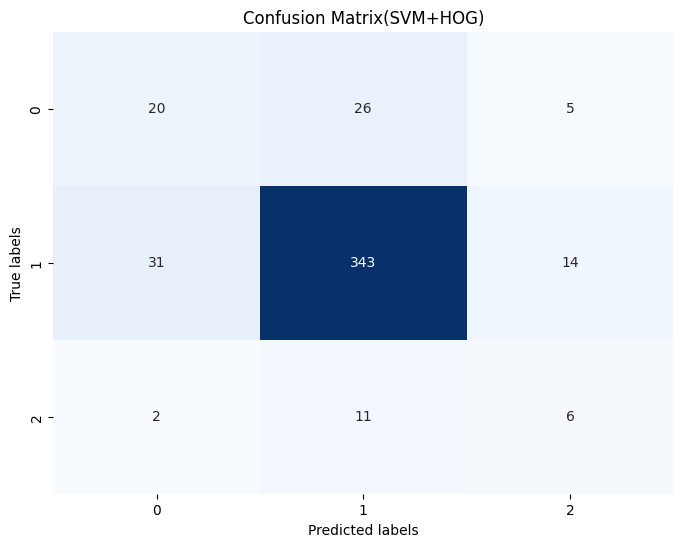

In [60]:
#confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix(SVM+HOG)')
# Save the figure
plt.savefig('confusion_matrix(SVM+HOG).png')
# Download the image
from google.colab import files
files.download('confusion_matrix(SVM+HOG).png')
plt.show()



In [26]:
# Generate classification report
report = classification_report(y_test, y_pred_test)

# Print classification report
print(report)


              precision    recall  f1-score   support

           0       0.38      0.39      0.38        51
           1       0.90      0.88      0.89       388
           2       0.24      0.32      0.27        19

    accuracy                           0.81       458
   macro avg       0.51      0.53      0.52       458
weighted avg       0.82      0.81      0.81       458



# Section G. SIFT

The code in this section for SIFT feature extraction and bag of visual words is adapted from Lab 4 and Lab 6.

###Step 1. SIFT - Extracting Key points and Feature Descriptors (Train)

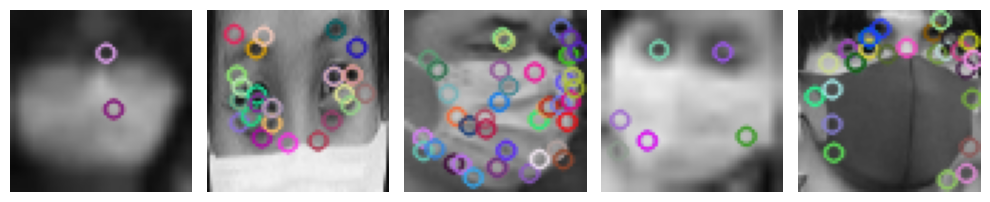

In [ ]:
#Initiate SIFT detector
sift_train = cv2.SIFT_create()

#Create empty lists for feature descriptors and labels (train)
descriptor_list = []
y_train_list = []

fig, ax = plt.subplots(1, 5, figsize=(10, 8), sharey=True)

for i in range(len(X_train)):
    #identifying keypoints and extracting descriptors with SIFT
    img = img_as_ubyte(X_train[i])
    kp, des = sift_train.detectAndCompute(img, None)

    #show results for first 5 images
    if i < 5:
        img_with_SIFT = cv2.drawKeypoints(img, kp, img)
        ax[i].imshow(img_with_SIFT, cmap='gray')
        ax[i].set_axis_off()

    #append list of descriptors and label to respective lists
    if des is not None:
        descriptor_list.append(des)
        y_train_list.append(y_train[i])


fig.tight_layout()
plt.show()

#Convert to array
descriptor_array = np.vstack(descriptor_list)


In [ ]:
len(descriptor_list)

3253

In [ ]:
len(descriptor_array)

63993

In [ ]:
len(y_train_list)

3253

In [ ]:
type(y_train_list)

list

### Step 2. Clustering of the Descriptors using K-Means (Train)

In [ ]:
#Number of centroids/codewords
k1 = len(np.unique(y_train)) * 30

batch_size = descriptor_array.shape[0] // 4
kmeans = MiniBatchKMeans(n_clusters=k1, batch_size=batch_size, n_init='auto').fit(descriptor_array)


### Step 3. Generating histograms of Codewords (Train)

In [ ]:
hist_train_list = []
idx_list = []

for des in descriptor_list:
    hist = np.zeros(k1)

    idx = kmeans.predict(des)
    idx_list.append(idx)
    for j in idx:
        hist[j] = hist[j] + (1 / len(des))
    hist_train_list.append(hist)

hist_train_array = np.vstack(hist_train_list)


### Step 4. Displaying Histograms (Train)

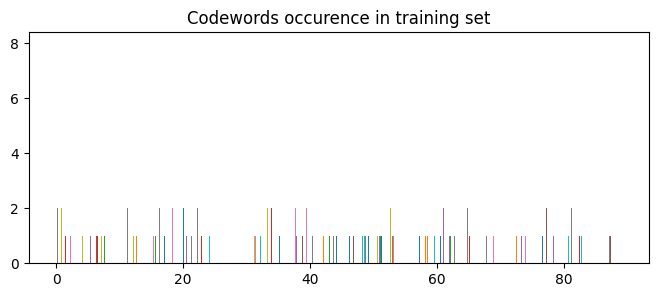

In [ ]:
fig, ax = plt.subplots(figsize=(8,3))
ax.hist(np.array(idx_list, dtype=object), bins=k1)
ax.set_title('Codewords occurence in training set')
plt.show()

In [ ]:
y_train_array = np.array(y_train_list)

len(y_train_array)

3253

### Step 5. SIFT - Extracting Key points and Feature Descriptors (Test)

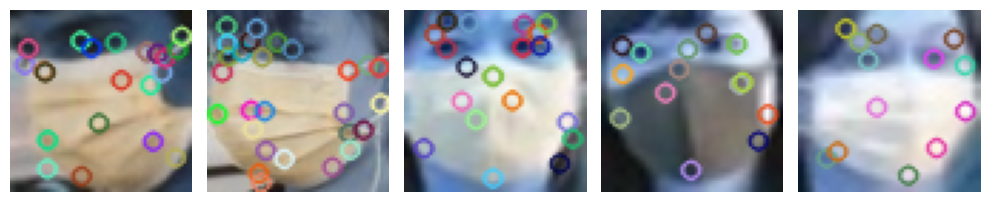

In [ ]:
#Initiate SIFT detector
sift_test = cv2.SIFT_create()

#create empty lists for feature descriptors and labels
descriptor_list_test = []
y_test_list = []

fig, ax = plt.subplots(1, 5, figsize=(10, 8), sharey=True)

for i in range(len(X_test)):
    #identifying keypoints and extracting descriptors with SIFT for each test image
    img_test = img_as_ubyte((X_test[i]))
    kp_test, des_test = sift_test.detectAndCompute(img_test, None)

    # Show results for first 5 test images
    if i < 5:
        img_with_SIFT_test = cv2.drawKeypoints(img_test, kp_test, img_test)
        ax[i].imshow(img_with_SIFT_test, cmap="gray")
        ax[i].set_axis_off()

    # Append list of descriptors and label to respective lists
    if des_test is not None:
        descriptor_list_test.append(des_test)
        y_test_list.append(y_test[i])

fig.tight_layout()
plt.show()

#Convert to array
descriptor_array_test = np.vstack(descriptor_list_test)



### Step 6. Clustering of the Descriptors using K-Means (Test)

In [ ]:
#Number of centroids/codewords
k1_test = len(np.unique(y_test)) * 30

batch_size_test = descriptor_array_test.shape[0] // 4
kmeans_test = MiniBatchKMeans(n_clusters=k1_test, batch_size=batch_size_test, n_init='auto').fit(descriptor_array_test)


### Step 7. Generating histograms of Codewords (Test)

In [ ]:
hist_test_list = []
idx_list_test = []

for des_test in descriptor_list_test:
    hist_test = np.zeros(k1_test)

    idx_test = kmeans.predict(des_test)
    idx_list_test.append(idx_test)
    for j in idx_test:
        hist_test[j] = hist_test[j] + (1 / len(des_test))
    hist_test_list.append(hist_test)

hist_test_array = np.vstack(hist_test_list)



### Step 8. Displaying Histograms (Test)

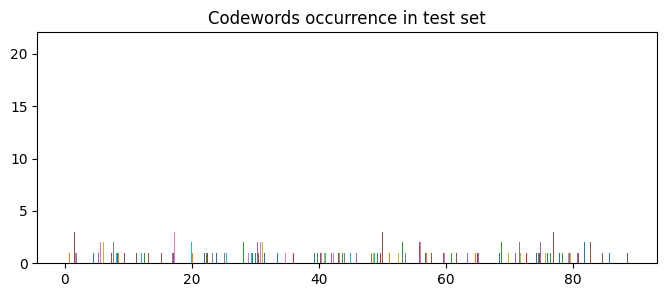

In [ ]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.hist(np.array(idx_list_test, dtype=object), bins=k1_test)
ax.set_title('Codewords occurrence in test set')
plt.show()



In [ ]:
y_test_array = np.array(y_test_list)

In [ ]:
len(y_test_array)

457

In [ ]:
# SIFT FOR VALIDATION IMAGES

### Step 9. SIFT - Extracting Key points and Feature Descriptors (Validation)

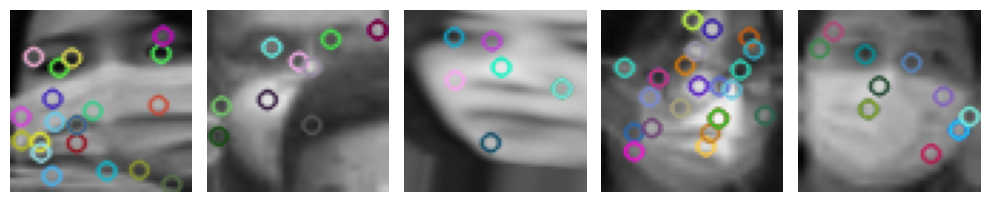

In [ ]:

#Initiate SIFT detector
sift_val = cv2.SIFT_create()

#creating empty lists for feature descriptors and labels
descriptor_list_val = []
y_val_list = []

fig, ax = plt.subplots(1, 5, figsize=(10, 8), sharey=True)

for i in range(len(X_val)):
    #identifying keypoints and extracting descriptors with SIFT for each val image
    img_val = img_as_ubyte((X_val[i]))
    kp_val, des_val = sift_val.detectAndCompute(img_val, None)

    #Show results for first 5 test images
    if i < 5:
        img_with_SIFT_val = cv2.drawKeypoints(img_val, kp_val, img_val)
        ax[i].imshow(img_with_SIFT_val, cmap="gray")
        ax[i].set_axis_off()

    #append list of descriptors and label to respective lists
    if des_val is not None:
        descriptor_list_val.append(des_val)
        y_val_list.append(y_val[i])

fig.tight_layout()
plt.show()

#Convert to array
descriptor_array_val = np.vstack(descriptor_list_val)

### Step 10. Clustering of the Descriptors using K-Means (Val)

In [ ]:
#Number of centroids/codewords
k1_val = len(np.unique(y_val)) * 30

batch_size_val = descriptor_array_val.shape[0] // 4
kmeans_val = MiniBatchKMeans(n_clusters=k1_val, batch_size=batch_size_val, n_init='auto').fit(descriptor_array_val)


### Step 11. Generating histograms of Codewords (Val)

In [ ]:
hist_val_list = []
idx_list_val = []

for des_val in descriptor_list_val:
    hist_val = np.zeros(k1_val)

    idx_val = kmeans.predict(des_val)
    idx_list_val.append(idx_val)
    for j in idx_val:
        hist_val[j] = hist_val[j] + (1 / len(des_val))
    hist_val_list.append(hist_val)

hist_val_array = np.vstack(hist_val_list)



### Step 12. Displaying Histograms (Val)

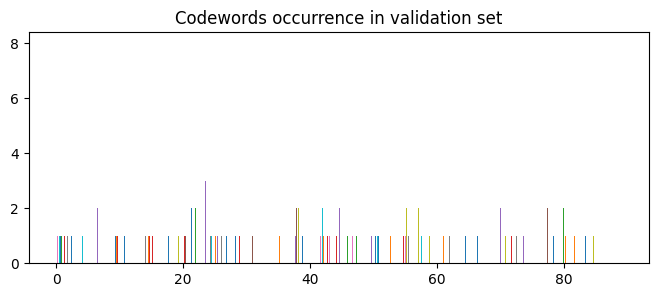

In [ ]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.hist(np.array(idx_list_val, dtype=object), bins=k1_val)
ax.set_title('Codewords occurrence in validation set')
plt.show()


In [ ]:
y_val_array = np.array(y_val_list)

In [ ]:
len(y_val_array)

811

In [ ]:
#This are the arrays generated for SIFT

#hist_train_array
#y_train_array

#hist_val_array
#y_val_array

#hist_test_array
#y_test_array

In [ ]:
#saving the sift arrays


# defining file paths to save the arrays
hist_train_array_file = '/content/drive/MyDrive/CW_Folder_PG/Formatted_Datasets/SIFT Arrays/hist_train_array.npy'
y_train_array_file = '/content/drive/MyDrive/CW_Folder_PG/Formatted_Datasets/SIFT Arrays/y_train_array.npy'

hist_val_array_file = '/content/drive/MyDrive/CW_Folder_PG/Formatted_Datasets/SIFT Arrays/hist_val_array.npy'
y_val_array_file = '/content/drive/MyDrive/CW_Folder_PG/Formatted_Datasets/SIFT Arrays/y_val_array.npy'

hist_test_array_file = '/content/drive/MyDrive/CW_Folder_PG/Formatted_Datasets/SIFT Arrays/hist_test_array.npy'
y_test_array_file = '/content/drive/MyDrive/CW_Folder_PG/Formatted_Datasets/SIFT Arrays/y_test_array.npy'


# Save NumPy arrays
np.save(hist_train_array_file, hist_train_array)
np.save(y_train_array_file, y_train_array)

np.save(hist_val_array_file, hist_val_array)
np.save(y_val_array_file, y_val_array)

np.save(hist_test_array_file, hist_test_array)
np.save(y_test_array_file, y_test_array)





# Section H. SIFT + MLP (Model 3)

I used this link to understand how to implement a MLP model.
https://www.kaggle.com/code/sathianpong/3-ways-to-implement-mlp-with-keras

####Step 1. Loading the data

In [ ]:
# Loading the arrays

# Define file paths for loading the arrays
hist_train_array_file = '/content/drive/MyDrive/CW_Folder_PG/Formatted_Datasets/SIFT Arrays/hist_train_array.npy'
y_train_array_file = '/content/drive/MyDrive/CW_Folder_PG/Formatted_Datasets/SIFT Arrays/y_train_array.npy'

hist_val_array_file = '/content/drive/MyDrive/CW_Folder_PG/Formatted_Datasets/SIFT Arrays/hist_val_array.npy'
y_val_array_file = '/content/drive/MyDrive/CW_Folder_PG/Formatted_Datasets/SIFT Arrays/y_val_array.npy'

hist_test_array_file = '/content/drive/MyDrive/CW_Folder_PG/Formatted_Datasets/SIFT Arrays/hist_test_array.npy'
y_test_array_file = '/content/drive/MyDrive/CW_Folder_PG/Formatted_Datasets/SIFT Arrays/y_test_array.npy'

# Load NumPy arrays
hist_train_array = np.load(hist_train_array_file)
y_train_array = np.load(y_train_array_file)

hist_val_array = np.load(hist_val_array_file)
y_val_array = np.load(y_val_array_file)

hist_test_array = np.load(hist_test_array_file)
y_test_array = np.load(y_test_array_file)


In [ ]:
# Converting arrays into a tensor

X_train_tensor_sift = tf.convert_to_tensor(hist_train_array)
y_train_tensor_sift = tf.convert_to_tensor(y_train_array)

X_val_tensor_sift = tf.convert_to_tensor(hist_val_array)
y_val_tensor_sift = tf.convert_to_tensor(y_val_array)

X_test_tensor_sift = tf.convert_to_tensor(hist_test_array)
y_test_tensor_sift = tf.convert_to_tensor(y_test_array)

####Step 2. Base Model

In [ ]:
#Set random seed for tensorflow
tf.random.set_seed(42)

#Set random seed for numpy
np.random.seed(42)

#defining the model architecture
model_mlp_sift_1 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=X_train_tensor_sift.shape[1:]),         #flattening the input images
    tf.keras.layers.Dense(128, activation='relu'),                              # First hidden layer with 128 units and ReLU activation
    tf.keras.layers.Dense(64, activation='relu'),                               # Second hidden layer with 64 units and ReLU activation
    tf.keras.layers.Dense(32, activation='relu'),                               # Third hidden layer with 32 units and ReLU activation
    tf.keras.layers.Dense(3, activation='softmax')                              #Output layer for 3 classes
])

# Compile the model
model_mlp_sift_1.compile(optimizer='adam',  #adam optimizer
              loss='sparse_categorical_crossentropy',  # Sparse categorical crossentropy loss
              metrics=['accuracy'])



#early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

#train the model
history = model_mlp_sift_1.fit(X_train_tensor_sift, y_train_tensor_sift, epochs=50, batch_size=32,
                    validation_data=(X_val_tensor_sift, y_val_tensor_sift), callbacks=[early_stopping])

#Accessing loss and accuracy
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

#print the final loss and accuracy
final_loss = train_loss[-1]
final_accuracy = train_accuracy[-1]
print("Final training loss:", final_loss)
print("Final training accuracy:", final_accuracy)

final_val_loss = val_loss[-1]
final_val_accuracy = val_accuracy[-1]
print("Final validation loss:", final_val_loss)
print("Final validation accuracy:", final_val_accuracy)


Epoch 1/50
102/102 [==============================] - 1s 5ms/step - loss: 0.9985 - accuracy: 0.4946 - val_loss: 0.8829 - val_accuracy: 0.5857
Epoch 2/50
102/102 [==============================] - 0s 3ms/step - loss: 0.8606 - accuracy: 0.5988 - val_loss: 0.8167 - val_accuracy: 0.6572
Epoch 3/50
102/102 [==============================] - 0s 3ms/step - loss: 0.8047 - accuracy: 0.6317 - val_loss: 0.7936 - val_accuracy: 0.6486
Epoch 4/50
102/102 [==============================] - 0s 3ms/step - loss: 0.7667 - accuracy: 0.6566 - val_loss: 0.7749 - val_accuracy: 0.6634
Epoch 5/50
102/102 [==============================] - 0s 3ms/step - loss: 0.7429 - accuracy: 0.6741 - val_loss: 0.7717 - val_accuracy: 0.6671
Epoch 6/50
102/102 [==============================] - 0s 3ms/step - loss: 0.7146 - accuracy: 0.6815 - val_loss: 0.8034 - val_accuracy: 0.6375
Epoch 7/50
102/102 [==============================] - 0s 3ms/step - loss: 0.6966 - accuracy: 0.6855 - val_loss: 0.7783 - val_accuracy: 0.6794
Epoch 

In [ ]:
#On test set

#the model on the test set
test_loss, test_accuracy = model_mlp_sift_1.evaluate(X_test_tensor_sift, y_test_tensor_sift)

#Printing the test loss and accuracy
print("Test loss:", test_loss)
print("Test accuracy:", test_accuracy)

15/15 [==============================] - 0s 2ms/step - loss: 0.5814 - accuracy: 0.7615
Test loss: 0.5814266800880432
Test accuracy: 0.7614879608154297


15/15 [==============================] - 0s 2ms/step


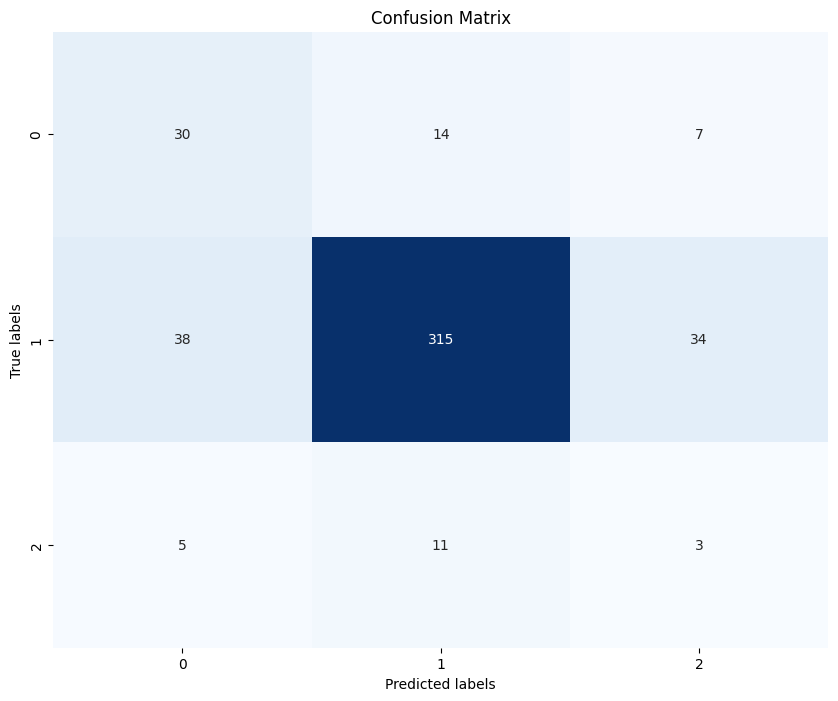

In [ ]:
#Confusion Matrix

#the predicted probabilities
y_pred_probs = model_mlp_sift_1.predict(X_test_tensor_sift)

#finding the predicted classes by finding the index of the maximum probability
y_pred = np.argmax(y_pred_probs, axis=1)

#confusion matrix
conf_matrix = confusion_matrix(y_test_tensor_sift, y_pred)

#Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

####Step 3. Tuning the MLP

In [ ]:
# defining the hyperparameters to tune
neurons_hidden1_options = [64, 128, 256]
neurons_hidden2_options = [64, 128, 256]
neurons_hidden3_options = [32, 64, 128]
dropout_rate_options = [0.0, 0.1, 0.2]
learning_rates = [0.001, 0.01, 0.1]
optimizers = ['adam', 'rmsprop', 'sgd']

best_accuracy = 0
best_hyperparameters = {}

# Iterate over each combination of hyperparameters
for neurons_hidden1 in neurons_hidden1_options:
    for neurons_hidden2 in neurons_hidden2_options:
        for neurons_hidden3 in neurons_hidden3_options:
            for dropout_rate in dropout_rate_options:
                for learning_rate in learning_rates:
                    for optimizer in optimizers:
                        print("Training model with neurons_hidden1={}, neurons_hidden2={}, neurons_hidden3={}, dropout_rate={}, learning_rate={}, optimizer={}".format(neurons_hidden1, neurons_hidden2, neurons_hidden3, dropout_rate, learning_rate, optimizer))

                        # defining the model architecture
                        model_mlp_sift_tuning = tf.keras.Sequential([
                            tf.keras.layers.Flatten(input_shape=X_train_tensor_sift.shape[1:]),
                            tf.keras.layers.Dense(neurons_hidden1, activation='relu'),
                            tf.keras.layers.Dropout(dropout_rate),
                            tf.keras.layers.Dense(neurons_hidden2, activation='relu'),
                            tf.keras.layers.Dropout(dropout_rate),
                            tf.keras.layers.Dense(neurons_hidden3, activation='relu'),
                            tf.keras.layers.Dropout(dropout_rate),
                            tf.keras.layers.Dense(3, activation='softmax')
                        ])

                        #Compiling the model
                        model_mlp_sift_tuning.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

                        #early stopping
                        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

                        #train the model with early stopping
                        history = model_mlp_sift_tuning.fit(X_train_tensor_sift, y_train_tensor_sift, epochs=50, batch_size=32,
                                            validation_data=(X_val_tensor_sift, y_val_tensor_sift), verbose=0,
                                            callbacks=[early_stopping])

                        #the model on validation data
                        _, accuracy = model_mlp_sift_tuning.evaluate(X_val_tensor_sift, y_val_tensor_sift, verbose=0)
                        print("Validation accuracy:", accuracy)

                        #Checking if this model has better accuracy than the previous best
                        if accuracy > best_accuracy:
                            best_accuracy = accuracy
                            best_hyperparameters = {'neurons_hidden1': neurons_hidden1, 'neurons_hidden2': neurons_hidden2,
                                                    'neurons_hidden3': neurons_hidden3,
                                                    'dropout_rate': dropout_rate, 'learning_rate': learning_rate,
                                                    'optimizer': optimizer}

                        #Printing accuracy for each combination
                        print("Accuracy for neurons_hidden1={}, neurons_hidden2={}, neurons_hidden3={}, dropout_rate={}, learning_rate={}, optimizer={}: {:.4f}".format(
                            neurons_hidden1, neurons_hidden2, neurons_hidden3, dropout_rate, learning_rate, optimizer, accuracy))

print("Best hyperparameters:", best_hyperparameters)
print("Best validation accuracy:", best_accuracy)


Training model with neurons_hidden1=64, neurons_hidden2=64, neurons_hidden3=32, dropout_rate=0.0, learning_rate=0.001, optimizer=adam
Restoring model weights from the end of the best epoch: 7.
Epoch 12: early stopping
Validation accuracy: 0.6769420504570007
Accuracy for neurons_hidden1=64, neurons_hidden2=64, neurons_hidden3=32, dropout_rate=0.0, learning_rate=0.001, optimizer=adam: 0.6769
Training model with neurons_hidden1=64, neurons_hidden2=64, neurons_hidden3=32, dropout_rate=0.0, learning_rate=0.001, optimizer=rmsprop
Restoring model weights from the end of the best epoch: 11.
Epoch 16: early stopping
Validation accuracy: 0.6683107018470764
Accuracy for neurons_hidden1=64, neurons_hidden2=64, neurons_hidden3=32, dropout_rate=0.0, learning_rate=0.001, optimizer=rmsprop: 0.6683
Training model with neurons_hidden1=64, neurons_hidden2=64, neurons_hidden3=32, dropout_rate=0.0, learning_rate=0.001, optimizer=sgd
Validation accuracy: 0.5980271100997925
Accuracy for neurons_hidden1=64, n

####Step 4. Creating the model with the best hyperparameters

In [ ]:
#random seed for tensorflow
tf.random.set_seed(42)

#random seed for numpy
np.random.seed(42)

# defining the model architecture
model_mlp_sift_best = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=X_train_tensor_sift.shape[1:]),  #flattening the input images
    tf.keras.layers.Dense(256, activation='relu'),                       #first hidden layer with 256 nuerons and ReLU activation
    tf.keras.layers.Dropout(0.0),                                        #Dropout layer with dropout rate of 0.0
    tf.keras.layers.Dense(64, activation='relu'),                        #Second hidden layer with 64 units and ReLU activation
    tf.keras.layers.Dropout(0.0),                                        #Dropout layer with dropout rate of 0.0
    tf.keras.layers.Dense(64, activation='relu'),                        #Third hidden layer with 64 units and ReLU activation
    tf.keras.layers.Dropout(0.0),                                        #Dropout layer with dropout rate of 0.0
    tf.keras.layers.Dense(3, activation='softmax')                       #Output layer for 3 classes
])

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model_mlp_sift_best.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',  # Sparse categorical crossentropy loss
              metrics=['accuracy'])


#Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

#Training the model with early stopping
history = model_mlp_sift_best.fit(X_train_tensor_sift, y_train_tensor_sift, epochs=50, batch_size=32,
                    validation_data=(X_val_tensor_sift, y_val_tensor_sift), callbacks=[early_stopping])

#accessing loss and accuracy
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

#Print the final loss and accuracy
final_loss = train_loss[-1]
final_accuracy = train_accuracy[-1]
print("Final training loss:", final_loss)
print("Final training accuracy:", final_accuracy)

final_val_loss = val_loss[-1]
final_val_accuracy = val_accuracy[-1]
print("Final validation loss:", final_val_loss)
print("Final validation accuracy:", final_val_accuracy)


Epoch 1/50
102/102 [==============================] - 1s 5ms/step - loss: 0.9565 - accuracy: 0.5423 - val_loss: 0.8568 - val_accuracy: 0.6498
Epoch 2/50
102/102 [==============================] - 0s 3ms/step - loss: 0.8462 - accuracy: 0.6151 - val_loss: 0.9337 - val_accuracy: 0.5697
Epoch 3/50
102/102 [==============================] - 0s 3ms/step - loss: 0.7895 - accuracy: 0.6385 - val_loss: 0.8036 - val_accuracy: 0.6289
Epoch 4/50
102/102 [==============================] - 0s 3ms/step - loss: 0.7274 - accuracy: 0.6800 - val_loss: 0.7437 - val_accuracy: 0.6880
Epoch 5/50
102/102 [==============================] - 0s 3ms/step - loss: 0.6521 - accuracy: 0.7156 - val_loss: 0.8142 - val_accuracy: 0.6671
Epoch 6/50
102/102 [==============================] - 0s 3ms/step - loss: 0.5676 - accuracy: 0.7651 - val_loss: 0.7813 - val_accuracy: 0.6634
Epoch 7/50
102/102 [==============================] - 0s 3ms/step - loss: 0.4823 - accuracy: 0.8088 - val_loss: 0.9412 - val_accuracy: 0.6708
Epoch 

#### Step 5. Saving the Model

In [ ]:
#Saving the model

#the directory and file path
file_path = "/content/drive/MyDrive/CW_Folder_PG/Models/model_mlp_sift_best.h5"

# Save the model
model_mlp_sift_best.save(file_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


####Step 6. Loading the Model

In [34]:
# Specify the path to the saved model
file_path = "/content/drive/MyDrive/CW_Folder_PG/Models/model_mlp_sift_best.h5"

# Load the model
model_mlp_sift_best = load_model(file_path)


#### Step 7. The Best Model on unseen test data

In [53]:
#evaluate the model on the test set
test_loss, test_accuracy = model_mlp_sift_best.evaluate(X_test_tensor_sift, y_test_tensor_sift)

#print the test loss and accuracy
print("Test loss:", test_loss)
print("Test accuracy:", test_accuracy)


15/15 [==============================] - 0s 2ms/step - loss: 0.5538 - accuracy: 0.7374
Test loss: 0.5537643432617188
Test accuracy: 0.7374179363250732


In [57]:
# Predict classes for the test data

# Calculate precision, recall, and F1-score
precision = precision_score(y_test_tensor_sift, y_pred_test, average='weighted')
recall = recall_score(y_test_tensor_sift, y_pred_test, average='weighted')
f1 = f1_score(y_test_tensor_sift, y_pred_test, average='weighted')

# Print precision, recall, and F1-score
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Precision: 0.8588128501695241
Recall: 0.737417943107221
F1-score: 0.7835944416673225


#### Step 8. Confusion matrix of best model

15/15 [==============================] - 0s 2ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

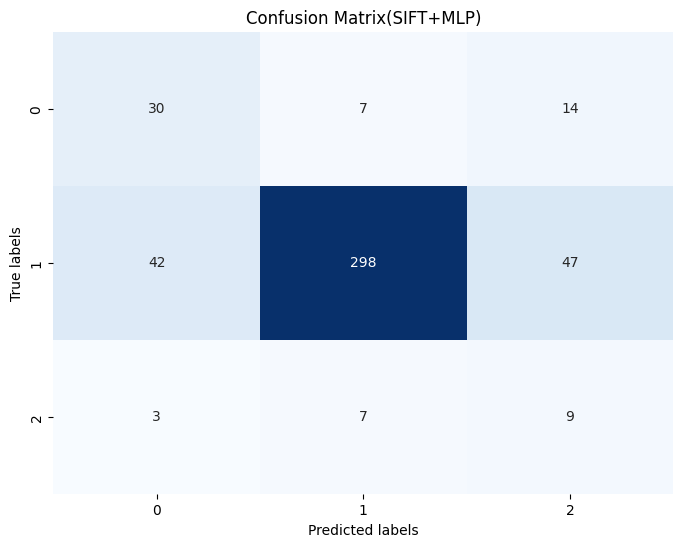

In [56]:
#predictions on the test set
y_pred_probs_test = model_mlp_sift_best.predict(X_test_tensor_sift)
y_pred_test = np.argmax(y_pred_probs_test, axis=1)

#the confusion matrix
conf_matrix = confusion_matrix(y_test_tensor_sift, y_pred_test)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix(SIFT+MLP)')
# Save the figure
plt.savefig('confusion_matrix(SIFT+MLP).png')
# Download the image
from google.colab import files
files.download('confusion_matrix(SIFT+MLP).png')
plt.show()

In [42]:
# Generate classification report
report = classification_report(y_test_tensor_sift, y_pred_test)

# Print classification report
print(report)


              precision    recall  f1-score   support

           0       0.40      0.59      0.48        51
           1       0.96      0.77      0.85       387
           2       0.13      0.47      0.20        19

    accuracy                           0.74       457
   macro avg       0.49      0.61      0.51       457
weighted avg       0.86      0.74      0.78       457



# Section I. CNN (Model 4)

I used this article to read about the architecture of Convolutional Neural Networks and how to implement them.

https://www.tensorflow.org/tutorials/images/cnn

#### Step 1. Loading the data

In [43]:
# Specify the directory where you saved the arrays
load_dir = "/content/drive/MyDrive/CW_Folder_PG/Formatted_Datasets/Augmented_arrays_(resized)/"

# Load the saved arrays
X_train_whole_cnn = np.load(os.path.join(load_dir, 'X_train_whole.npy'))
y_train_whole_cnn = np.load(os.path.join(load_dir, 'y_train_whole.npy'))
X_test_cnn = np.load(os.path.join(load_dir, 'X_test.npy'))
y_test_cnn = np.load(os.path.join(load_dir, 'y_test.npy'))


#### Step 2. Preprocessing for CNN

In [ ]:


#function to preprocess images
def preprocess_images_cnn(images):
    preprocessed_images = []
    for img in images:

        #Normalizing
        normalized_img = img / 255.0

        preprocessed_images.append(normalized_img)
    return np.array(preprocessed_images)

X_train_whole_preprocessed_cnn = preprocess_images_cnn(X_train_whole_cnn)

X_test_preprocessed_cnn = preprocess_images_cnn(X_test_cnn)


In [ ]:
from sklearn.model_selection import train_test_split

#Splitting the training data into training and validation sets
X_train_cnn, X_val_cnn, y_train_cnn, y_val_cnn = train_test_split(X_train_whole_preprocessed_cnn, y_train_whole_cnn, test_size=0.2, random_state=42)


#### Step 3. CNN Base Model

In [ ]:
#The dimensions of the image
image_height = 64
image_width = 64

#Defining the CNN model architecture
basemodel_cnn = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(image_height, image_width, 3)),  #Convolution Layer 1
    layers.MaxPooling2D((2, 2)),                                                               #Pooling Layer
    layers.Conv2D(64, (3, 3), activation='relu'),                                              #Convolution Layer 2
    layers.MaxPooling2D((2, 2)),                                                               #Pooling Layer
    layers.Conv2D(64, (3, 3), activation='relu'),                                              #Convolution Layer 3
    layers.Flatten(),                                                                          #Flatten layer
    layers.Dense(64, activation='relu'),                                                       #Dense layer
    layers.Dense(3, activation='softmax')                                                      #Output layer
])

#Compiling the model
basemodel_cnn.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

#Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

#Training the CNN Model
history = basemodel_cnn.fit(X_train_cnn, y_train_cnn, epochs=50, batch_size=32,
                        validation_data=(X_val_cnn, y_val_cnn), callbacks=[early_stopping])

#Validation accuracy and validation loss obtained during training
print("Validation Accuracy:", history.history['val_accuracy'])
print("Validation Loss:", history.history['val_loss'])


#The model on the unseen test data
test_loss, test_acc = basemodel_cnn.evaluate(X_test_cnn, y_test_cnn)
print("Test Accuracy:", test_acc)


Epoch 1/50
103/103 [==============================] - 7s 57ms/step - loss: 0.6146 - accuracy: 0.7489 - val_loss: 0.3853 - val_accuracy: 0.8641
Epoch 2/50
103/103 [==============================] - 5s 51ms/step - loss: 0.4407 - accuracy: 0.8395 - val_loss: 0.3331 - val_accuracy: 0.8886
Epoch 3/50
103/103 [==============================] - 5s 50ms/step - loss: 0.3377 - accuracy: 0.8726 - val_loss: 0.3527 - val_accuracy: 0.8531
Epoch 4/50
103/103 [==============================] - 6s 55ms/step - loss: 0.2991 - accuracy: 0.8885 - val_loss: 0.4252 - val_accuracy: 0.8470
Epoch 5/50
103/103 [==============================] - 5s 50ms/step - loss: 0.3853 - accuracy: 0.8557 - val_loss: 0.3167 - val_accuracy: 0.8911
Epoch 6/50
103/103 [==============================] - 5s 52ms/step - loss: 0.2560 - accuracy: 0.9078 - val_loss: 0.2419 - val_accuracy: 0.9070
Epoch 7/50
103/103 [==============================] - 5s 52ms/step - loss: 0.2337 - accuracy: 0.9096 - val_loss: 0.2210 - val_accuracy: 0.9217

15/15 [==============================] - 0s 17ms/step


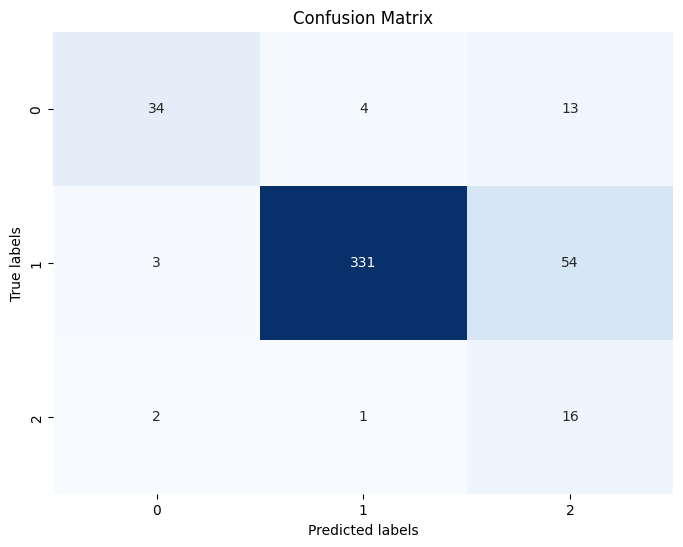

In [ ]:
#Array of predicted class labels
y_pred_test = np.argmax(basemodel_cnn.predict(X_test_cnn), axis=1)

#Confusion matrix
conf_matrix = confusion_matrix(y_test_cnn, y_pred_test)

#Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


####Step 4. Hyperparameter Tuning For CNN

I used this documentation to understand about kerastuner.
https://www.tensorflow.org/tutorials/keras/keras_tuner

I implemented this code after watching this youtube video on Kerastuner.
https://www.youtube.com/watch?v=oYnyNLj8RMA&t=1152s


In [ ]:
#The dimensions of the image
image_height = 64
image_width = 64

def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(hp.Int('conv1_units', min_value=32, max_value=128, step=32), (3, 3), activation='relu', input_shape=(image_height, image_width, 3))) #Convolution layer 1
    model.add(keras.layers.MaxPooling2D((2, 2))) #Pooling layer
    model.add(keras.layers.Conv2D(hp.Int('conv2_units', min_value=32, max_value=128, step=32), (3, 3), activation='relu')) #Convolution layer 2
    model.add(keras.layers.MaxPooling2D((2, 2))) #Pooling Layer
    model.add(keras.layers.Conv2D(hp.Int('conv3_units', min_value=32, max_value=128, step=32), (3, 3), activation='relu')) #Convolution layer 3
    model.add(keras.layers.Flatten()) #Flatten layer
    model.add(keras.layers.Dense(hp.Int('dense_units', min_value=64, max_value=256, step=64), activation='relu')) #Dense layer
    model.add(keras.layers.Dense(3, activation='softmax'))  #Output layer

    optimizer_choice = hp.Choice('optimizer', values=['adam', 'sgd'])
    if optimizer_choice == 'adam':
        optimizer = keras.optimizers.Adam(hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001]))
    else:
        optimizer = keras.optimizers.SGD(hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001]))

    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

#Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

#Initializing a Random Search to get the best hyperparameters
tuner = RandomSearch(
    build_model,                    #Function that definingd the model architecture
    objective='val_accuracy',       #Metric to optimize for
    max_trials=30,                  #Number of combinations
    executions_per_trial=1,         #Number of execution for each combination
    directory=None,
    project_name=None,
)

#Starting the search
tuner.search(X_train_cnn, y_train_cnn, epochs=5, validation_data=(X_val_cnn, y_val_cnn), callbacks=[early_stopping])

#Best hyperparameters combination
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:", best_hyperparameters)



Trial 30 Complete [00h 00m 48s]
val_accuracy: 0.8470011949539185

Best val_accuracy So Far: 0.9118726849555969
Total elapsed time: 00h 40m 42s
Best Hyperparameters: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x78daddfc2b00>


In [ ]:
#The top 5 best performing models
tuner.results_summary(num_trials=5)

Results summary
Results in ./untitled_project
Showing 5 best trials
Objective(name="val_accuracy", direction="max")

Trial 15 summary
Hyperparameters:
conv1_units: 32
conv2_units: 64
conv3_units: 64
dense_units: 256
optimizer: adam
learning_rate: 0.0001
Score: 0.9118726849555969

Trial 00 summary
Hyperparameters:
conv1_units: 96
conv2_units: 32
conv3_units: 128
dense_units: 192
optimizer: adam
learning_rate: 0.0001
Score: 0.9106487035751343

Trial 08 summary
Hyperparameters:
conv1_units: 128
conv2_units: 96
conv3_units: 32
dense_units: 192
optimizer: adam
learning_rate: 0.0001
Score: 0.9057527780532837

Trial 17 summary
Hyperparameters:
conv1_units: 32
conv2_units: 96
conv3_units: 128
dense_units: 128
optimizer: adam
learning_rate: 0.0001
Score: 0.9057527780532837

Trial 18 summary
Hyperparameters:
conv1_units: 96
conv2_units: 96
conv3_units: 128
dense_units: 192
optimizer: adam
learning_rate: 0.0001
Score: 0.9057527780532837


In [ ]:
# This was the best model

#Hyperparameters:
#conv1_units: 32
#conv2_units: 64
#conv3_units: 64
#dense_units: 256
#optimizer: adam
#learning_rate: 0.0001
#Score: 0.9118726849555969

#### Step 5. Creating a new model with the best hyperparameters

In [ ]:
##The dimensions of the image
image_height = 64
image_width = 64

#Defining the CNN model architecture
model_cnn = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(image_height, image_width, 3)), #Convolution layer 1
    layers.MaxPooling2D((2, 2)),                                                              #Pooling layer
    layers.Conv2D(64, (3, 3), activation='relu'),                                             #Convolution layer 2
    layers.MaxPooling2D((2, 2)),                                                              #Pooling layer
    layers.Conv2D(64, (3, 3), activation='relu'),                                             #Convolution layer 3
    layers.Flatten(),                                                                         #Flatten layer
    layers.Dense(256, activation='relu'),                                                     #Dense layer
    layers.Dense(3, activation='softmax')                                                     #Output layer
])

#Defining the optimizer with the learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

#Compiling the model
model_cnn.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

#Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

#Training the CNN model
history = model_cnn.fit(X_train_cnn, y_train_cnn, epochs=50, batch_size=32,
                        validation_data=(X_val_cnn, y_val_cnn), callbacks=[early_stopping])

#Validation accuracy and validation loss obtained during training
print("Validation Accuracy:", history.history['val_accuracy'])
print("Validation Loss:", history.history['val_loss'])

#The best model on the unseen test data
test_loss, test_acc = model_cnn.evaluate(X_test_cnn, y_test_cnn)
print(" Accuracy:", test_acc)


Epoch 1/50
103/103 [==============================] - 8s 63ms/step - loss: 0.6990 - accuracy: 0.7041 - val_loss: 0.4361 - val_accuracy: 0.8507
Epoch 2/50
103/103 [==============================] - 7s 68ms/step - loss: 0.4490 - accuracy: 0.8374 - val_loss: 0.3311 - val_accuracy: 0.8825
Epoch 3/50
103/103 [==============================] - 7s 70ms/step - loss: 0.3820 - accuracy: 0.8560 - val_loss: 0.3153 - val_accuracy: 0.8886
Epoch 4/50
103/103 [==============================] - 7s 68ms/step - loss: 0.3793 - accuracy: 0.8567 - val_loss: 0.3051 - val_accuracy: 0.8947
Epoch 5/50
103/103 [==============================] - 8s 75ms/step - loss: 0.3555 - accuracy: 0.8714 - val_loss: 0.2667 - val_accuracy: 0.9082
Epoch 6/50
103/103 [==============================] - 7s 69ms/step - loss: 0.3053 - accuracy: 0.8861 - val_loss: 0.2603 - val_accuracy: 0.9070
Epoch 7/50
103/103 [==============================] - 7s 71ms/step - loss: 0.2959 - accuracy: 0.8904 - val_loss: 0.2509 - val_accuracy: 0.9033

####Step 6. Saving the best CNN Model

In [ ]:
#Specifying the file path
model_path = '/content/drive/MyDrive/CW_Folder_PG/Models/model_cnn.h5'

#Saving the model
model_cnn.save(model_path)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### Step 7. Loading the best CNN Model

In [44]:
from keras.models import load_model

#Specifying the path to the saved model
model_path = '/content/drive/MyDrive/CW_Folder_PG/Models/model_cnn.h5'

# Load the model
model_cnn = load_model(model_path)

####Step 8. The best model on the test set

In [45]:
#The best model on the test data
test_loss, test_acc = model_cnn.evaluate(X_test_cnn, y_test_cnn)
print(" Accuracy:", test_acc)

15/15 [==============================] - 0s 21ms/step - loss: 97.3416 - accuracy: 0.8734
 Accuracy: 0.8733624219894409


In [48]:
# Calculate precision, recall, and F1-score
precision = precision_score(y_test_cnn, y_pred_test, average='weighted')
recall = recall_score(y_test_cnn, y_pred_test, average='weighted')
f1 = f1_score(y_test_cnn, y_pred_test, average='weighted')

# Print precision, recall, and F1-score
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Precision: 0.9389654002071447
Recall: 0.8733624454148472
F1-score: 0.8974819597600228


#### Step 9. Confusion matrix of best cnn model

15/15 [==============================] - 0s 21ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

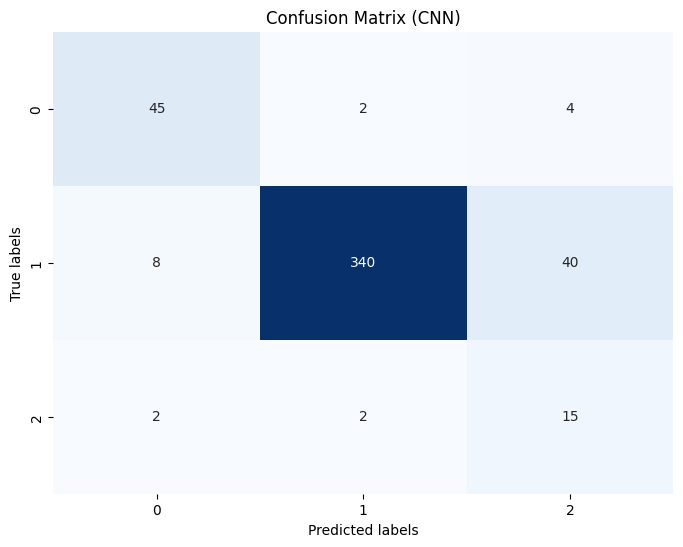

In [52]:
#Array of predicted class labels
y_pred_test = np.argmax(model_cnn.predict(X_test_cnn), axis=1)

#Confusion matrix
conf_matrix = confusion_matrix(y_test_cnn, y_pred_test)

#Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix (CNN)')
# Save the figure
plt.savefig('confusion_matrix_cnn.png')
# Download the image
from google.colab import files
files.download('confusion_matrix_cnn.png')
plt.show()


In [50]:
# Generate classification report
report = classification_report(y_test_cnn, y_pred_test)

# Print classification report
print(report)


              precision    recall  f1-score   support

           0       0.82      0.88      0.85        51
           1       0.99      0.88      0.93       388
           2       0.25      0.79      0.38        19

    accuracy                           0.87       458
   macro avg       0.69      0.85      0.72       458
weighted avg       0.94      0.87      0.90       458

